# MREN223 Lab1 - Pedometer

In this lab, we will look at frequency spectrums, Fourier analysis, and signal filtering to design a pedometer. 

A pedometer counts each step a person takes by detecting the motion of the person's hands or hips. We will use the inertial measurement unit (IMU), containing a 3-axis accelerometer, on an Arduino Nano to generate motion data of a hand, and then process this data to count the number of steps.

In this lab, we will be using the following libraries:
`pip install scipy numpy matplotlib`

We advise you to scroll down to the lab description, and do steps (1) and (2) to get the Arduino work started. As it is taking its time to upload the sketch to the board, you can come up here and read the lab introduction. 

In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
%matplotlib inline

## Learning outcomes

1. Learn to compute the Fourier and inverse Fourier transforms in Python
2. Understand and generate frequency spectrums
3. Understand and generate frequency response
4. Learn filter types, how to design a filter and apply it to a signal
5. Apply FFT and filter design to design a pedometer

## Fast Fourier Transform

FFT is an algorithm which enables the calculation of the discrete Fourier Transform (DFT) efficiently.

We will start with an exercise to see what `fft` does. Recall that the fourier transform of a discrete signal $x[n]$ with period $N$ is
$$y[k] = \sum_{n=0}^{N-1} x[n] e^{-j \frac{2 \pi}{N} k}$$

*Exercise:* Consider the discrete signal $x[n]$ which involves a repeating pattern $[1,2,1,-1,1]$. Calculate its Fourier transform $y[k]$.

We will now compute $y[k]$ using `scipy.fft.fft`.

In [2]:
x = np.array([1.0, 2.0, 1.0, -1.0, 1])

y = fft(x)
y

array([ 4.        -0.j        ,  1.92705098-2.12662702j,
       -1.42705098+1.31432778j, -1.42705098-1.31432778j,
        1.92705098+2.12662702j])

We can retreive $x[n]$ by computing the inverse Fourier transform using `scipy.fft.ifft`

In [3]:
yinv = ifft(y)
yinv

array([ 1.+0.j,  2.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])

###  Visualizing FFT: Frequency Spectrum

Let's now consider the sum of two complex exponential signals with frequencies $1$ and $5$ Hz.

$$y(t) = e^{j \omega_1 t} + e^{j \omega_2 t}$$
$$y[n] = y(nT_s)$$
$$\omega_1 = 2\pi(1), \omega_2 = 2\pi(5) \text{rad/s}$$

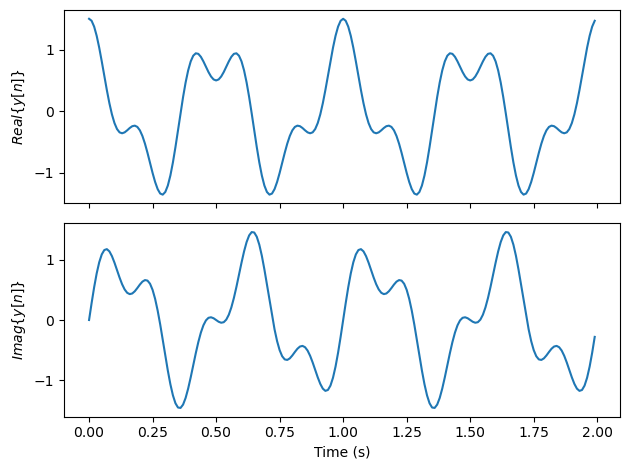

In [4]:
# number of signal points and sample spacing
N, Ts = (200,  1./100.)

t = np.linspace(0.0, N*Ts, N, endpoint=False)
y = np.exp(2 * 1.j * 2.0*np.pi * t) + 0.5*np.exp(5 * 1.j * 2.0*np.pi * t)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, np.real(y))
ax1.set_ylabel('$Real\{y[n]\}$')

ax2.plot(t, np.imag(y))
ax2.set_ylabel('$Imag\{y[n]\}$')

ax2.set_xlabel('Time (s)')
plt.tight_layout()

The FFT plot of a signal, called the **frequency spectrum** of the signal, displays the frequencies within that signal. For example, the frequency spectrum of the sum of complex exponential signals shows two peaks at the frequencies $1$ and $5$ Hz. 

The magnitude of the peaks informs of the coefficients preceding each exponential, showing that the $1$ Hz component is larger (or more dominant).

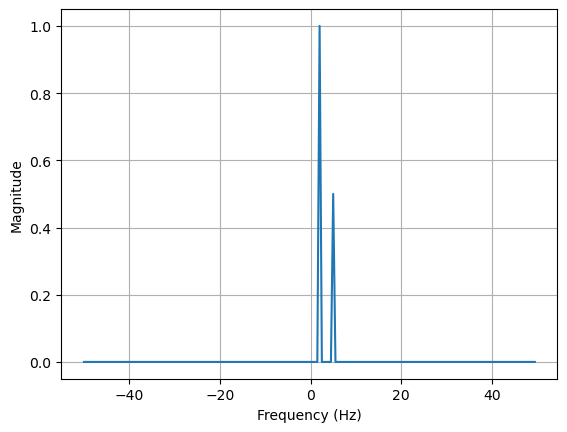

In [5]:
yf = fft(y) # fft of the signal 

xf = fftfreq(N, Ts)
xf = fftshift(xf) #  preparing the x-axis for the spectrum

yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()

Similarly, we can do the same with sinusoidal signals. Consider a composite signal of three sinosoids with frequencies $3$ and $5$ and $40$ Hz and a ramp as given by

$$y(t) = cos(2\pi(3) t) + cos(2\pi(5) t) + cos(2\pi(40) t) + 0.1t$$
$$y[n] = y(nTs)$$

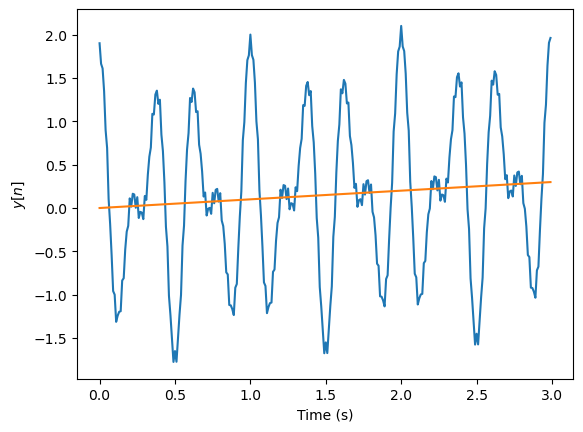

In [6]:
# Number of sample points
N, Ts = (300, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

y = np.cos(3.0 * 2.0*np.pi*t) + 0.8*np.cos(5.0 * 2.0*np.pi*t) + 0.1*t + 0.1*np.cos(40.0 * 2.0*np.pi*t)

plt.plot(t, y)
plt.plot(t, 0.1*t)
plt.xlabel('Time (s)')
plt.ylabel('$y[n]$');

We find in the frequency spectrum peaks for each of these three frequencies and a peak at 0 rad/s for the ramp.

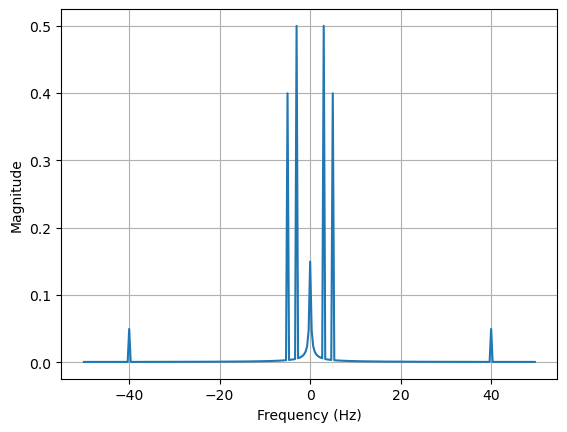

In [7]:
yf = fft(y)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid();

## Filtering

We will now design a filter to remove the frequencies we may not want in the signal.

Filters can be categorized into four categories:
1) low-pass: passes low frequencies and attenuates high frequencies
2) high-pass: passes high frequencies and attenuates low frequencies
3) band-pass: passes frequencies within a specified frequency range and attenuates all other frequencies
4) band-stop: attenutaes frequencies within a specified frequency range and passes all other frequencies

The `butterworth` filter in `scipy` provides a function which enables designing any of these filters with ease.
We will design a band-pass filter to filter out the ramp and the high frequency harmonic in the above composite signal.

First, we will visualize the filter.

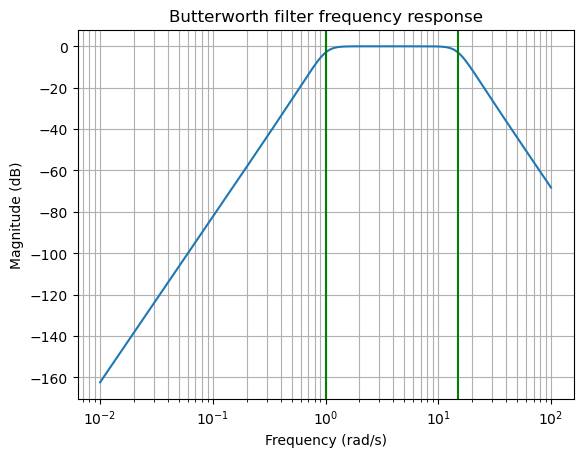

In [8]:
b, a = signal.butter(4, [1, 15], 'bandpass', analog=True)  #4 is filter order, the higher the more precise the filter, 
                                                            #[1,15] band of frequencies in rad/s to pass
w, h = signal.freqs(b, a) # computes the filter's frequency response

plt.semilogx(w, 20*np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both', axis='both')

plt.axvline(1, color='green') 
plt.axvline(15, color='green');

A filter's **frequency response** displays the action of the filter on different frequencies. 
The x-axis is the frequency in the input signal and the y-axis is the magnitude of amplification of that frequency in the input signal. 

The y-axis is logarithmic, in units of dB ($=20 \log_{10}(\text{Magnitude})$). A magnitude of 1 = 0 dB; hence, frequencies that 'see' a response of 0 dB are passed as they are. Frequencies that see a response higher (lower) that 0 dB are amplified (attentuated). 

The band of the bandpass filter is between the green vertical lines.

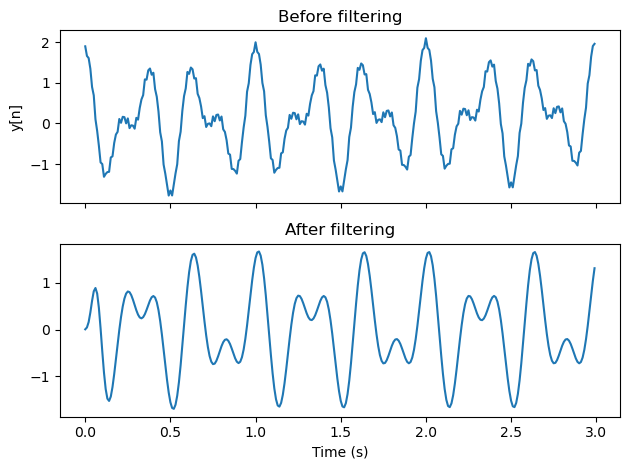

In [9]:
sig = y # signal from before
sos = signal.butter(4, [1, 10], 'bandpass', fs=100, output='sos')
filtered = signal.sosfilt(sos, sig) # filtered signal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, sig)
ax1.set_title('Before filtering')
ax1.set_ylabel('y[n]')

ax2.plot(t, filtered)
ax2.set_title('After filtering')
ax1.set_ylabel('y[n]')

ax2.set_xlabel('Time (s)')
plt.tight_layout();

To confirm that the unwanted frequencies have been filtered out, we will plot the frequency spectrum of $y[n]$ following filtering.

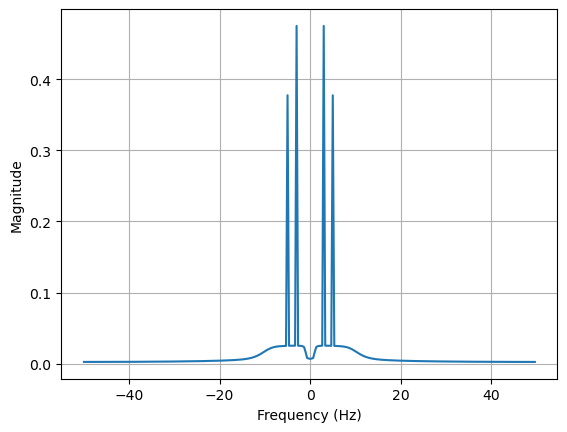

In [10]:
y = filtered
yf = fft(y)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid();

## Lab Description

Retreive one Arduino Nano 33 BLE for your group. 

Arduino is available on Queen's lab computers on AppsAnywhere. Access https://apps.engineering.queensu.ca and open the Arduino IDE. You might have to open it twice, as it might fail to open the first time.

If you are new to Arduino, have a look at the Arduino provided tutorials:https://www.arduino.cc/en/Tutorial/HomePage
or https://technobyte.org/arduino-ide-complete-guide-beginners/

Once you have familiarized yourself with Arduino. We will do the following:

1) Follow the following tutorial (https://docs.arduino.cc/tutorials/nano-33-ble/imu-accelerometer), specific to Arduino Nano 33 BLE, to learn how to retrieve accelerometer data. 
The tutorial prints the accelerometer data to the Arduino IDE Serial window (https://www.arduino.cc/reference/en/language/functions/communication/serial/)

Make sure you have done all the following:
- Installed the board manager: Tools -> Boards Manager -> Arduino Mbed OS Nano Boards
- Installed the library: Tools -> Manage Libraries -> LSM9DS1
- Collected the accelerometer example code: File -> Examples -> Examples for any board -> Arduino_LSM9DS1 -> Simple Accelerometer
- Selected the board: Tools -> Board -> Arduino Mbed OS Nano Boards -> Arduino Nano 33 BLE; 
- Selected the port: Tools -> Port: COM# (Arduino Nano 33 BLE); 

2) Compile and upload the accelerometer example to the Arduino. This might take some time. 

3) Open the Serial monitor. Confirm that the accelerometer's x,y, and z values are printing onto the Serial monitor. 
You can clear the output on the Serial monitor.

4) Hold the Arduino Nano in your hand and simulate a few walking steps while collecting accelerometer data from the Arduino. 
Keep a count of your steps. 
Your lab partner(s) can inspect the Arduino Serial plotter as you walk to get an idea of how the data looks like for one walking step.
Select all (Ctrl-A) and copy (Ctrl-C) the accelerometer output from the Serial monitor.
Collect data for 3 runs, each with a different step count, to validate your method.

5) Import the accelerometer data into Python.
Have one array hold each of the accelerometer x, y and z axes output signal.

6) Plot (visualize) each of the output signals from the accelerometer x, y and z axes. Compute the magnitude of the acceleration that you will process to count the number of steps. Your aim is to develop a strategy to count the steps from the signal(s).
You can resample the accelerometer data at a lower sampling rate (if you wish to).

7) Pre-process the data: trim the data (for example, you may want to remove some of the initial collected data before you actually started walking); design a filter to remove any noise or unwanted drift from the selected signal(s); etc. 
- Plot the filter's frequency response.
- Plot a section of the selected signal(s) before and after filtering.
- Plot the frequency spectrum(s) of the selected signal(s) before and after filtering.

8) Write a python function that reads accelerometer data [float array] and outputs the number of steps taken [int].


## Grading Scheme
Collecting acceleration data (5 points);
Plotting acceleration data (4 points);
Filter frequency response (3 points);
Signal before and after filtering (3 points);
Frequency spectrum before and after filtering (3 points);
Function that computes number of steps (2 points).

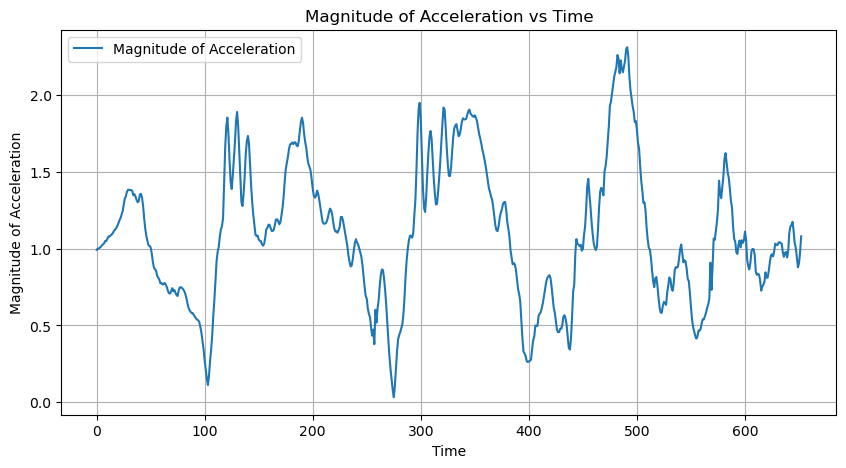

In [11]:
import math

# Initialize three empty lists to store the values from each column
column1 = []
column2 = []
column3 = []

# Read the data from the file or use it as a string directly
data = """
0.74	-0.66	0.02
0.75	-0.66	0.01
0.75	-0.66	0.01
0.76	-0.66	0.01
0.76	-0.67	0.01
0.77	-0.67	0.02
0.77	-0.68	0.03
0.78	-0.68	0.03
0.79	-0.69	0.04
0.79	-0.69	0.04
0.80	-0.70	0.04
0.82	-0.70	0.03
0.82	-0.70	0.02
0.83	-0.70	0.01
0.83	-0.71	0.00
0.84	-0.71	0.01
0.86	-0.71	0.00
0.87	-0.71	0.00
0.88	-0.71	0.00
0.89	-0.72	0.00
0.91	-0.72	0.01
0.93	-0.73	0.01
0.94	-0.74	0.01
0.96	-0.75	0.01
0.98	-0.76	-0.01
1.01	-0.79	-0.02
1.03	-0.83	-0.04
1.05	-0.83	-0.04
1.07	-0.85	-0.06
1.08	-0.86	-0.07
1.08	-0.86	-0.07
1.07	-0.87	-0.06
1.07	-0.87	-0.06
1.07	-0.86	-0.07
1.05	-0.84	-0.06
1.06	-0.84	-0.05
1.04	-0.84	-0.04
1.02	-0.83	-0.03
1.01	-0.82	-0.01
1.02	-0.82	-0.02
1.04	-0.86	-0.06
1.03	-0.88	-0.05
1.01	-0.87	-0.03
0.98	-0.82	0.00
0.94	-0.74	0.02
0.90	-0.68	0.04
0.87	-0.64	0.07
0.85	-0.61	0.08
0.83	-0.59	0.07
0.84	-0.57	0.07
0.84	-0.55	0.08
0.82	-0.51	0.08
0.78	-0.47	0.09
0.76	-0.43	0.08
0.76	-0.41	0.05
0.76	-0.39	0.04
0.74	-0.36	0.03
0.73	-0.35	0.03
0.73	-0.32	0.04
0.72	-0.28	0.04
0.73	-0.26	0.05
0.73	-0.22	0.07
0.74	-0.20	0.07
0.75	-0.19	0.07
0.74	-0.18	0.08
0.73	-0.15	0.07
0.71	-0.13	0.05
0.70	-0.11	0.03
0.70	-0.10	0.02
0.72	-0.07	0.01
0.74	-0.06	0.01
0.72	-0.05	-0.00
0.73	-0.01	0.01
0.71	0.02	0.04
0.69	0.06	0.07
0.68	0.08	0.10
0.71	0.10	0.14
0.72	0.12	0.16
0.72	0.13	0.16
0.71	0.14	0.17
0.70	0.16	0.16
0.69	0.16	0.15
0.67	0.18	0.14
0.63	0.21	0.14
0.58	0.24	0.15
0.53	0.27	0.16
0.49	0.30	0.17
0.44	0.34	0.19
0.39	0.38	0.20
0.34	0.42	0.21
0.29	0.44	0.21
0.23	0.46	0.21
0.19	0.47	0.20
0.15	0.48	0.19
0.11	0.49	0.18
0.08	0.49	0.16
0.07	0.46	0.15
0.07	0.43	0.12
0.07	0.38	0.08
0.08	0.33	0.05
0.10	0.25	0.03
0.11	0.18	0.02
0.10	0.11	0.03
0.11	0.02	0.01
0.15	-0.09	0.01
0.18	-0.20	0.02
0.20	-0.28	0.02
0.24	-0.37	0.00
0.30	-0.48	-0.02
0.35	-0.57	-0.01
0.41	-0.68	-0.03
0.45	-0.80	-0.01
0.45	-0.87	0.01
0.44	-0.91	0.00
0.45	-0.98	-0.01
0.45	-1.03	-0.03
0.43	-1.06	-0.07
0.44	-1.11	-0.10
0.56	-1.30	-0.12
0.71	-1.50	-0.10
0.77	-1.62	-0.05
0.80	-1.67	0.02
0.73	-1.58	0.05
0.61	-1.45	0.04
0.51	-1.34	-0.00
0.48	-1.30	-0.07
0.53	-1.37	-0.13
0.62	-1.45	-0.15
0.70	-1.53	-0.16
0.76	-1.66	-0.11
0.80	-1.71	-0.04
0.73	-1.64	0.01
0.60	-1.51	0.05
0.46	-1.37	0.06
0.32	-1.26	0.04
0.26	-1.25	0.01
0.30	-1.32	-0.02
0.40	-1.41	-0.05
0.51	-1.53	-0.09
0.56	-1.60	-0.09
0.58	-1.63	-0.09
0.55	-1.59	-0.04
0.47	-1.47	-0.00
0.39	-1.35	0.02
0.31	-1.26	0.01
0.26	-1.19	0.01
0.23	-1.13	0.01
0.21	-1.07	-0.01
0.21	-1.06	-0.01
0.18	-1.07	-0.00
0.14	-1.05	0.01
0.14	-1.04	0.03
0.12	-1.04	0.05
0.11	-1.02	0.06
0.12	-1.01	0.06
0.12	-1.02	0.07
0.12	-1.06	0.08
0.14	-1.11	0.11
0.14	-1.12	0.11
0.15	-1.14	0.11
0.15	-1.14	0.10
0.15	-1.12	0.09
0.16	-1.10	0.08
0.16	-1.10	0.07
0.16	-1.11	0.05
0.19	-1.14	0.05
0.20	-1.17	0.07
0.20	-1.17	0.09
0.19	-1.16	0.09
0.19	-1.14	0.07
0.20	-1.15	0.06
0.23	-1.19	0.03
0.29	-1.23	0.00
0.33	-1.29	-0.03
0.38	-1.38	-0.04
0.44	-1.45	-0.04
0.48	-1.48	-0.05
0.51	-1.51	-0.07
0.55	-1.55	-0.09
0.58	-1.57	-0.10
0.59	-1.57	-0.11
0.59	-1.58	-0.10
0.59	-1.57	-0.08
0.60	-1.58	-0.06
0.60	-1.58	-0.03
0.60	-1.56	0.00
0.58	-1.56	0.04
0.56	-1.60	0.04
0.53	-1.68	0.05
0.53	-1.74	0.08
0.53	-1.77	0.12
0.51	-1.74	0.15
0.49	-1.67	0.15
0.47	-1.62	0.14
0.44	-1.59	0.13
0.39	-1.54	0.10
0.34	-1.51	0.08
0.30	-1.50	0.08
0.27	-1.48	0.09
0.23	-1.43	0.08
0.21	-1.37	0.06
0.18	-1.33	0.05
0.17	-1.32	0.03
0.17	-1.33	0.03
0.20	-1.36	0.07
0.19	-1.34	0.10
0.17	-1.30	0.13
0.15	-1.25	0.16
0.15	-1.20	0.16
0.14	-1.16	0.14
0.11	-1.15	0.13
0.08	-1.15	0.14
0.13	-1.14	0.20
0.18	-1.15	0.17
0.23	-1.17	0.14
0.27	-1.20	0.12
0.28	-1.22	0.14
0.28	-1.21	0.13
0.27	-1.18	0.14
0.25	-1.13	0.16
0.21	-1.10	0.14
0.16	-1.09	0.14
0.14	-1.09	0.17
0.16	-1.08	0.16
0.21	-1.09	0.15
0.23	-1.11	0.15
0.24	-1.17	0.16
0.25	-1.17	0.15
0.25	-1.15	0.11
0.19	-1.12	0.11
0.16	-1.08	0.14
0.15	-1.04	0.13
0.12	-1.00	0.14
0.12	-0.94	0.13
0.13	-0.90	0.10
0.14	-0.87	0.07
0.17	-0.87	0.06
0.22	-0.90	0.07
0.29	-0.94	0.09
0.38	-0.96	0.09
0.44	-0.96	0.10
0.45	-0.93	0.11
0.46	-0.91	0.12
0.43	-0.90	0.09
0.43	-0.87	0.09
0.43	-0.84	0.07
0.43	-0.78	0.06
0.42	-0.70	0.06
0.40	-0.63	0.07
0.38	-0.57	0.10
0.39	-0.53	0.14
0.38	-0.44	0.18
0.39	-0.36	0.22
0.40	-0.28	0.26
0.37	-0.16	0.27
0.33	-0.03	0.28
0.38	0.13	0.25
0.20	0.02	0.32
0.24	0.40	0.38
0.29	0.38	0.20
0.24	0.47	0.31
0.13	0.55	0.35
0.10	0.66	0.36
0.11	0.74	0.36
0.14	0.79	0.32
0.16	0.80	0.27
0.16	0.76	0.21
0.15	0.70	0.14
0.14	0.61	0.09
0.11	0.50	0.06
0.09	0.39	0.04
0.05	0.29	0.04
0.01	0.21	0.04
0.00	0.15	0.01
0.00	0.08	-0.01
0.01	0.01	-0.03
0.03	-0.09	-0.05
0.06	-0.21	-0.04
0.09	-0.32	-0.02
0.09	-0.40	0.01
0.08	-0.43	0.03
0.07	-0.45	0.03
0.06	-0.48	0.02
0.04	-0.51	0.00
0.03	-0.58	-0.03
0.02	-0.69	-0.05
0.04	-0.83	-0.05
0.06	-0.93	-0.01
0.06	-1.00	0.02
0.07	-1.05	0.04
0.07	-1.08	0.06
0.04	-1.08	0.06
-0.00	-1.07	0.03
-0.02	-1.10	-0.05
0.01	-1.21	-0.12
0.08	-1.30	-0.19
0.10	-1.49	-0.26
0.25	-1.73	-0.18
0.39	-1.87	-0.00
0.48	-1.88	0.17
0.50	-1.74	0.25
0.43	-1.53	0.28
0.29	-1.34	0.22
0.13	-1.25	0.12
-0.01	-1.23	0.14
-0.02	-1.33	0.14
0.06	-1.48	0.19
0.17	-1.59	0.26
0.29	-1.67	0.31
0.41	-1.68	0.35
0.45	-1.61	0.37
0.41	-1.49	0.35
0.30	-1.39	0.30
0.19	-1.32	0.26
0.10	-1.26	0.24
0.05	-1.27	0.22
0.07	-1.35	0.21
0.13	-1.44	0.20
0.21	-1.54	0.19
0.29	-1.66	0.19
0.40	-1.76	0.18
0.51	-1.84	0.17
0.55	-1.82	0.11
0.53	-1.71	0.03
0.47	-1.59	-0.03
0.41	-1.49	-0.05
0.35	-1.43	-0.05
0.30	-1.44	-0.04
0.29	-1.50	-0.03
0.32	-1.60	-0.02
0.39	-1.68	0.01
0.47	-1.72	0.02
0.53	-1.72	0.02
0.56	-1.72	0.01
0.56	-1.68	-0.00
0.52	-1.65	-0.02
0.49	-1.67	-0.03
0.48	-1.71	-0.01
0.48	-1.76	0.02
0.49	-1.78	0.05
0.50	-1.77	0.07
0.49	-1.77	0.10
0.47	-1.78	0.10
0.46	-1.81	0.11
0.47	-1.83	0.12
0.47	-1.84	0.13
0.44	-1.82	0.14
0.44	-1.81	0.15
0.44	-1.80	0.16
0.42	-1.80	0.17
0.41	-1.81	0.20
0.38	-1.80	0.20
0.33	-1.79	0.17
0.27	-1.76	0.14
0.19	-1.73	0.12
0.11	-1.71	0.09
0.03	-1.68	0.07
-0.04	-1.64	0.04
-0.09	-1.61	0.04
-0.11	-1.57	0.04
-0.15	-1.53	0.07
-0.17	-1.48	0.07
-0.18	-1.43	0.07
-0.16	-1.38	0.09
-0.11	-1.36	0.10
-0.08	-1.33	0.12
-0.07	-1.31	0.13
-0.07	-1.26	0.14
-0.09	-1.20	0.13
-0.12	-1.14	0.10
-0.11	-1.11	0.08
-0.05	-1.11	0.07
0.04	-1.14	0.08
0.11	-1.19	0.08
0.15	-1.22	0.09
0.17	-1.24	0.07
0.21	-1.27	0.05
0.23	-1.28	0.05
0.24	-1.28	0.04
0.24	-1.23	0.04
0.23	-1.15	0.01
0.21	-1.11	0.01
0.20	-1.06	0.03
0.14	-0.98	0.03
0.21	-0.92	-0.01
0.22	-0.87	0.03
0.25	-0.87	0.03
0.28	-0.85	0.04
0.27	-0.82	0.05
0.25	-0.76	0.05
0.22	-0.70	0.05
0.21	-0.66	0.13
0.16	-0.62	0.15
0.13	-0.52	0.09
0.11	-0.40	0.06
0.12	-0.30	0.07
0.18	-0.26	0.04
0.21	-0.20	0.08
0.22	-0.14	0.06
0.22	-0.09	0.11
0.23	-0.03	0.13
0.23	0.02	0.14
0.22	0.08	0.15
0.27	0.12	0.18
0.30	0.16	0.22
0.30	0.21	0.22
0.35	0.28	0.22
0.26	0.29	0.31
0.39	0.27	0.15
0.46	0.27	0.18
0.47	0.28	0.18
0.49	0.29	0.14
0.53	0.29	0.11
0.57	0.29	0.10
0.61	0.32	0.06
0.64	0.37	0.03
0.67	0.40	0.02
0.69	0.42	0.00
0.69	0.44	-0.01
0.68	0.47	-0.02
0.65	0.48	-0.05
0.61	0.44	-0.05
0.57	0.37	-0.05
0.54	0.29	-0.06
0.54	0.19	-0.11
0.50	0.09	-0.13
0.45	0.01	-0.14
0.42	-0.08	-0.16
0.40	-0.15	-0.16
0.40	-0.20	-0.17
0.39	-0.25	-0.12
0.37	-0.32	-0.13
0.36	-0.40	-0.15
0.36	-0.41	-0.15
0.37	-0.38	-0.12
0.32	-0.38	-0.06
0.25	-0.34	0.01
0.20	-0.29	-0.01
0.16	-0.30	0.05
0.15	-0.38	0.09
0.13	-0.53	0.13
0.18	-0.69	0.10
0.29	-0.71	0.03
0.23	-0.93	0.15
0.28	-0.99	0.26
0.30	-0.96	0.23
0.23	-0.97	0.24
0.19	-0.96	0.27
0.16	-0.99	0.21
0.13	-0.97	0.12
0.11	-0.99	0.06
0.13	-1.08	-0.01
0.21	-1.12	-0.05
0.28	-1.22	-0.10
0.34	-1.36	-0.08
0.35	-1.41	-0.03
0.31	-1.32	0.03
0.25	-1.25	0.02
0.19	-1.16	0.01
0.13	-1.09	0.02
0.10	-1.03	0.04
0.10	-1.00	0.01
0.14	-0.98	-0.03
0.16	-1.00	-0.03
0.20	-1.11	-0.06
0.22	-1.25	-0.09
0.21	-1.35	-0.11
0.23	-1.37	-0.13
0.23	-1.35	-0.14
0.28	-1.31	-0.13
0.41	-1.42	-0.26
0.46	-1.44	-0.27
0.51	-1.48	-0.32
0.60	-1.55	-0.33
0.69	-1.62	-0.35
0.74	-1.71	-0.50
0.81	-1.69	-0.56
0.88	-1.72	-0.55
0.94	-1.75	-0.55
0.99	-1.80	-0.52
1.01	-1.82	-0.53
1.03	-1.86	-0.48
1.11	-1.91	-0.47
1.10	-1.88	-0.49
1.13	-1.76	-0.45
1.20	-1.74	-0.69
1.16	-1.74	-0.58
1.07	-1.78	-0.54
1.07	-1.85	-0.44
1.07	-1.91	-0.38
1.09	-1.97	-0.44
1.02	-2.02	-0.46
1.03	-1.97	-0.36
0.92	-1.88	-0.34
0.83	-1.82	-0.36
0.81	-1.76	-0.40
0.76	-1.71	-0.46
0.72	-1.68	-0.48
0.67	-1.65	-0.39
0.67	-1.67	-0.33
0.63	-1.63	-0.29
0.57	-1.57	-0.24
0.52	-1.55	-0.22
0.42	-1.46	-0.23
0.32	-1.39	-0.20
0.25	-1.34	-0.19
0.19	-1.27	-0.18
0.18	-1.28	-0.14
0.17	-1.22	-0.17
0.10	-1.11	-0.20
0.05	-1.04	-0.18
0.01	-1.00	-0.10
0.00	-0.98	-0.16
0.05	-0.93	-0.12
0.08	-0.85	-0.07
0.08	-0.78	-0.08
0.10	-0.74	-0.06
0.16	-0.79	0.02
0.22	-0.78	0.08
0.23	-0.72	0.00
0.25	-0.63	-0.05
0.25	-0.55	-0.12
0.26	-0.50	-0.15
0.27	-0.48	-0.19
0.34	-0.50	-0.17
0.40	-0.50	-0.13
0.42	-0.47	-0.14
0.44	-0.44	-0.12
0.52	-0.48	-0.09
0.56	-0.50	-0.11
0.61	-0.52	-0.13
0.63	-0.48	-0.12
0.60	-0.41	-0.16
0.60	-0.36	-0.19
0.65	-0.37	-0.19
0.74	-0.38	-0.22
0.76	-0.35	-0.27
0.77	-0.32	-0.27
0.78	-0.31	-0.27
0.84	-0.31	-0.27
0.91	-0.36	-0.19
0.94	-0.38	-0.16
0.90	-0.34	-0.13
0.87	-0.26	-0.06
0.89	-0.24	-0.06
0.89	-0.21	-0.06
0.85	-0.17	-0.08
0.79	-0.12	-0.07
0.78	-0.10	-0.06
0.71	-0.05	-0.04
0.62	0.02	-0.01
0.53	0.10	0.02
0.46	0.16	0.05
0.41	0.20	0.07
0.36	0.22	0.09
0.33	0.24	0.07
0.32	0.27	0.09
0.34	0.30	0.11
0.31	0.33	0.11
0.29	0.37	0.09
0.33	0.38	0.12
0.37	0.37	0.14
0.38	0.36	0.13
0.40	0.37	0.14
0.43	0.37	0.14
0.47	0.37	0.14
0.49	0.38	0.15
0.54	0.38	0.13
0.83	0.34	0.14
0.60	0.31	0.28
0.85	0.23	0.03
0.96	0.38	0.26
1.00	0.34	0.03
1.05	0.36	-0.04
1.09	0.43	-0.00
1.18	0.41	-0.09
1.37	0.41	-0.18
1.31	0.34	-0.11
1.30	0.27	-0.02
1.38	0.22	-0.04
1.46	0.16	-0.07
1.58	-0.07	-0.05
1.59	-0.28	-0.14
1.51	-0.35	-0.12
1.44	-0.40	-0.02
1.39	-0.44	-0.08
1.33	-0.39	-0.10
1.26	-0.34	-0.11
1.21	-0.32	-0.19
1.09	-0.22	-0.26
1.01	-0.12	-0.31
0.98	-0.07	-0.35
0.92	-0.06	-0.32
0.92	-0.13	-0.26
0.98	-0.22	-0.21
1.00	-0.25	-0.21
0.95	-0.27	-0.20
0.98	-0.22	-0.32
0.94	-0.18	-0.40
0.94	-0.18	-0.44
1.00	-0.17	-0.45
0.95	-0.14	-0.45
0.82	-0.07	-0.43
0.79	-0.02	-0.40
0.76	-0.03	-0.41
0.78	-0.06	-0.46
0.81	-0.08	-0.55
0.84	-0.14	-0.52
0.86	-0.20	-0.46
0.85	-0.17	-0.41
0.77	-0.11	-0.34
0.72	-0.03	-0.41
0.71	0.04	-0.44
0.71	0.01	-0.43
0.69	-0.03	-0.39
0.64	-0.04	-0.34
0.69	-0.07	-0.29
0.72	-0.13	-0.22
0.75	-0.09	-0.21
0.81	-0.03	-0.24
0.76	0.01	-0.28
0.75	0.02	-0.31
0.77	0.00	-0.37
0.82	-0.08	-0.39
0.87	-0.13	-0.37
0.88	-0.09	-0.38
0.85	-0.04	-0.42
0.85	-0.01	-0.49
0.86	0.00	-0.57
0.84	0.02	-0.59
0.84	0.03	-0.58
0.88	-0.01	-0.55
0.91	-0.09	-0.50
0.94	-0.17	-0.40
0.97	-0.15	-0.32
0.93	-0.06	-0.29
0.90	0.02	-0.29
0.91	0.03	-0.34
0.92	0.09	-0.32
0.90	0.12	-0.25
0.95	0.07	-0.25
1.07	-0.04	-0.25
1.11	-0.14	-0.23
1.12	-0.17	-0.21
1.13	-0.15	-0.28
1.06	-0.13	-0.32
0.99	-0.08	-0.29
0.96	-0.00	-0.30
0.90	0.04	-0.27
0.84	0.09	-0.24
0.85	0.13	-0.28
0.92	0.07	-0.32
1.02	-0.05	-0.35

 
"""

# Split the data into lines and iterate through each line
for line in data.strip().split('\n'):
    # Split each line into three values using whitespace as the delimiter
    values = line.split()
    
    # Convert each value to float and append it to the corresponding list
    column1.append(float(values[0]))
    column2.append(float(values[1]))
    column3.append(float(values[2]))

# Calculating the magnitude of acceleration at each point in time
magnitude = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in zip(column1, column2, column3)]

# Creating a time array
time = range(len(column1))

# Plotting the magnitude of acceleration against time
plt.figure(figsize=(10, 5))
plt.plot(time, magnitude, label='Magnitude of Acceleration')
plt.xlabel('Time')
plt.ylabel('Magnitude of Acceleration')
plt.title('Magnitude of Acceleration vs Time')
plt.legend()
plt.grid(True)
plt.show()

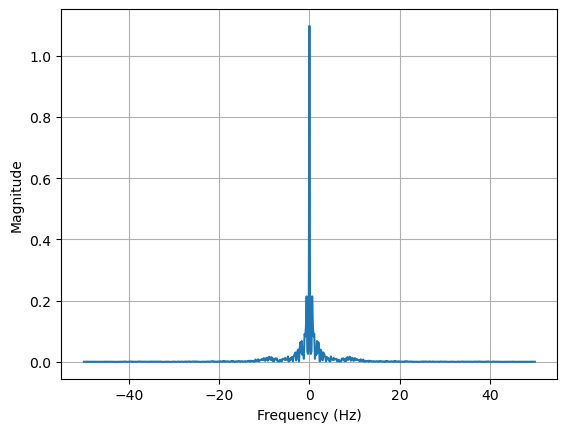

In [12]:
# Number of sample points
N, Ts = (653, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

yf = fft(magnitude)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid();

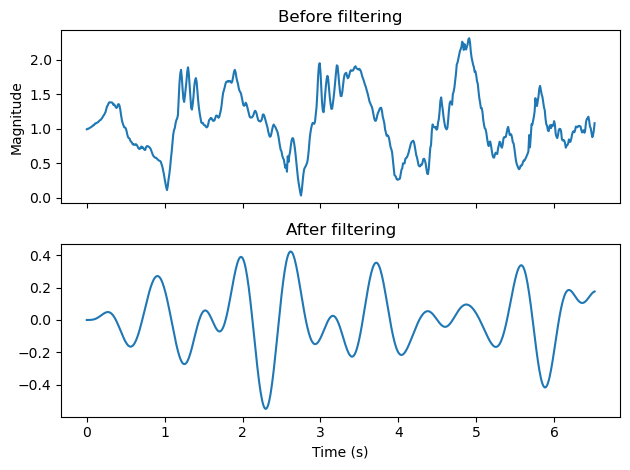

In [13]:
sig = magnitude # signal from before
sos = signal.butter(4, [1, 2], 'bandpass', fs=100, output='sos')
filtered = signal.sosfilt(sos, sig) # filtered signal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, sig)
ax1.set_title('Before filtering')
ax1.set_ylabel('Magnitude')

ax2.plot(t, filtered)
ax2.set_title('After filtering')
ax1.set_ylabel('Magnitude')

ax2.set_xlabel('Time (s)')
plt.tight_layout();

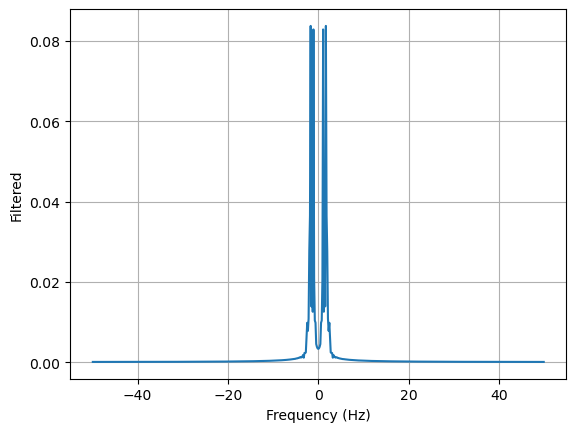

In [14]:
# Number of sample points
N, Ts = (653, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

yf = fft(filtered)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filtered')
plt.grid();

In [15]:
# Assume filtered_data is your filtered signal
# Define a threshold value for the peak. You may need to adjust this based on your signal characteristics.
threshold = 0.17  # Example threshold value, adjust as needed

peak_count = 0
above_threshold = False

for value in filtered:
    if value > threshold and not above_threshold:
        # Signal crosses above the threshold
        above_threshold = True
    elif value < threshold and above_threshold:
        # Signal drops below the threshold after being above it
        peak_count += 1
        above_threshold = False

print("Number of peaks:", peak_count)

Number of peaks: 6


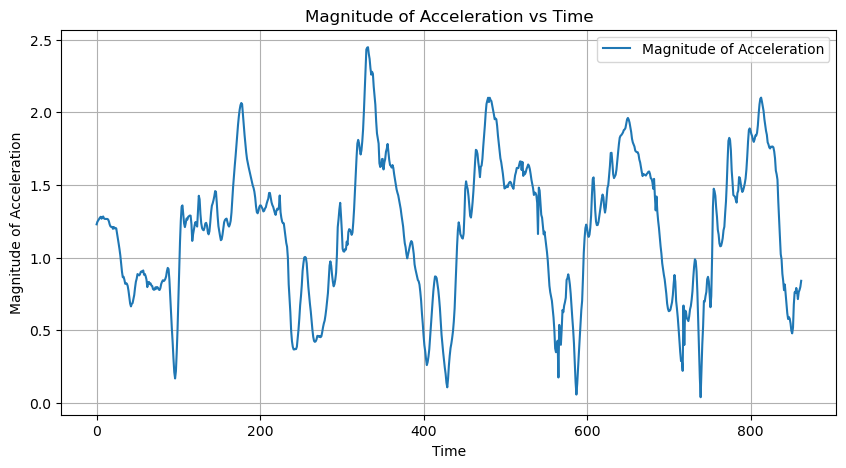

In [16]:

# Initialize three empty lists to store the values from each column
column1 = []
column2 = []
column3 = []

# Read the data from the file or use it as a string directly
data = """

1.13	0.48	0.07
1.15	0.48	0.07
1.16	0.48	0.06
1.17	0.48	0.06
1.18	0.48	0.07
1.19	0.47	0.07
1.18	0.46	0.07
1.19	0.46	0.08
1.20	0.45	0.07
1.19	0.44	0.06
1.19	0.43	0.06
1.19	0.43	0.06
1.19	0.43	0.06
1.19	0.43	0.06
1.19	0.42	0.06
1.18	0.41	0.05
1.16	0.40	0.05
1.15	0.39	0.04
1.15	0.38	0.03
1.15	0.38	0.03
1.14	0.37	0.02
1.15	0.38	0.01
1.14	0.38	0.01
1.14	0.39	-0.00
1.14	0.38	-0.01
1.11	0.36	-0.01
1.08	0.34	-0.01
1.05	0.31	-0.02
1.02	0.28	-0.02
0.98	0.26	-0.04
0.93	0.22	-0.05
0.88	0.20	-0.05
0.84	0.20	-0.06
0.84	0.21	-0.07
0.82	0.20	-0.08
0.79	0.21	-0.07
0.79	0.22	-0.09
0.79	0.20	-0.10
0.78	0.17	-0.11
0.75	0.14	-0.12
0.71	0.10	-0.12
0.67	0.05	-0.13
0.65	0.01	-0.14
0.67	-0.01	-0.13
0.68	-0.02	-0.10
0.71	-0.02	-0.08
0.74	-0.00	-0.07
0.79	-0.00	-0.07
0.83	-0.02	-0.08
0.85	-0.04	-0.09
0.88	-0.03	-0.11
0.87	-0.03	-0.15
0.86	-0.05	-0.17
0.86	-0.06	-0.20
0.87	-0.07	-0.23
0.87	-0.08	-0.24
0.86	-0.09	-0.26
0.86	-0.12	-0.28
0.83	-0.11	-0.28
0.82	-0.14	-0.31
0.80	-0.16	-0.31
0.77	-0.16	-0.32
0.71	-0.19	-0.31
0.73	-0.23	-0.32
0.73	-0.23	-0.33
0.71	-0.25	-0.32
0.70	-0.28	-0.33
0.66	-0.31	-0.35
0.63	-0.35	-0.36
0.59	-0.37	-0.36
0.55	-0.41	-0.37
0.52	-0.45	-0.37
0.49	-0.50	-0.38
0.44	-0.53	-0.38
0.41	-0.57	-0.38
0.38	-0.59	-0.37
0.33	-0.61	-0.36
0.28	-0.63	-0.36
0.23	-0.66	-0.37
0.21	-0.70	-0.37
0.20	-0.72	-0.37
0.19	-0.74	-0.36
0.18	-0.75	-0.33
0.15	-0.77	-0.31
0.12	-0.79	-0.30
0.09	-0.82	-0.28
0.07	-0.86	-0.28
0.07	-0.89	-0.26
0.07	-0.89	-0.23
0.06	-0.83	-0.18
0.03	-0.72	-0.14
0.00	-0.62	-0.11
0.02	-0.51	-0.07
0.05	-0.41	-0.07
0.08	-0.29	-0.06
0.12	-0.16	-0.07
0.14	-0.03	-0.09
0.16	0.12	-0.09
0.19	0.28	-0.09
0.24	0.44	-0.09
0.33	0.61	-0.09
0.42	0.80	-0.09
0.52	0.97	-0.13
0.62	1.08	-0.17
0.72	1.12	-0.23
0.77	1.08	-0.30
0.76	1.01	-0.31
0.74	0.95	-0.28
0.74	0.93	-0.23
0.79	0.94	-0.15
0.83	0.96	-0.05
0.84	0.94	0.06
0.87	0.93	0.14
0.88	0.92	0.18
0.88	0.93	0.16
0.89	0.93	0.07
0.84	0.90	0.02
0.71	0.86	0.03
0.72	0.91	-0.02
0.71	0.96	-0.03
0.68	1.02	0.00
0.67	1.05	0.01
0.65	1.04	0.04
0.64	1.03	0.06
0.71	1.11	0.03
0.80	1.18	-0.04
0.80	1.15	-0.05
0.71	1.09	-0.01
0.62	1.07	0.02
0.55	1.07	0.05
0.52	1.07	0.08
0.51	1.07	0.09
0.51	1.09	0.08
0.54	1.11	0.06
0.55	1.11	0.05
0.53	1.10	0.03
0.49	1.07	0.01
0.45	1.07	0.00
0.43	1.10	0.00
0.44	1.16	-0.01
0.48	1.22	-0.01
0.53	1.25	0.01
0.57	1.25	0.03
0.60	1.26	0.04
0.62	1.28	0.05
0.66	1.30	0.03
0.67	1.29	0.01
0.62	1.23	-0.00
0.56	1.16	-0.01
0.50	1.11	-0.01
0.46	1.09	0.00
0.42	1.07	0.02
0.39	1.05	0.03
0.38	1.06	0.03
0.39	1.09	0.04
0.40	1.13	0.04
0.42	1.17	0.04
0.41	1.19	0.05
0.40	1.20	0.05
0.38	1.21	0.05
0.33	1.20	0.07
0.27	1.19	0.09
0.21	1.19	0.12
0.16	1.21	0.14
0.11	1.24	0.15
0.08	1.30	0.15
0.10	1.39	0.13
0.14	1.48	0.09
0.19	1.55	0.07
0.27	1.61	0.05
0.36	1.66	0.03
0.47	1.71	0.01
0.61	1.75	-0.01
0.73	1.77	-0.02
0.85	1.78	-0.03
0.97	1.77	-0.03
1.05	1.76	-0.04
1.11	1.74	-0.04
1.14	1.71	-0.06
1.10	1.65	-0.06
1.05	1.59	-0.06
0.98	1.56	-0.08
0.91	1.53	-0.08
0.83	1.51	-0.07
0.75	1.50	-0.08
0.68	1.50	-0.09
0.61	1.50	-0.10
0.54	1.50	-0.09
0.47	1.50	-0.07
0.40	1.49	-0.06
0.34	1.48	-0.05
0.28	1.47	-0.03
0.17	1.47	-0.04
0.09	1.45	-0.07
0.05	1.41	-0.09
0.04	1.35	-0.09
0.06	1.31	-0.07
0.11	1.30	-0.05
0.18	1.31	-0.03
0.22	1.33	-0.00
0.23	1.34	0.02
0.22	1.34	0.05
0.20	1.33	0.07
0.19	1.32	0.08
0.19	1.30	0.11
0.22	1.30	0.11
0.25	1.31	0.12
0.28	1.31	0.14
0.30	1.33	0.15
0.33	1.34	0.17
0.35	1.35	0.18
0.40	1.38	0.16
0.41	1.38	0.13
0.39	1.35	0.13
0.34	1.33	0.15
0.29	1.32	0.17
0.25	1.31	0.21
0.23	1.29	0.23
0.24	1.26	0.26
0.30	1.23	0.27
0.36	1.24	0.29
0.43	1.23	0.30
0.51	1.20	0.27
0.52	1.21	0.28
0.59	1.27	0.28
0.52	1.20	0.13
0.35	1.21	0.19
0.41	1.17	0.14
0.30	1.18	0.22
0.45	1.15	0.06
0.42	1.11	0.12
0.46	1.05	0.03
0.44	1.01	0.03
0.42	0.99	-0.01
0.47	0.87	-0.14
0.31	0.75	-0.09
0.22	0.66	-0.18
0.16	0.57	-0.20
0.11	0.43	-0.22
0.11	0.34	-0.23
0.14	0.26	-0.25
0.16	0.23	-0.24
0.18	0.19	-0.26
0.19	0.11	-0.30
0.17	-0.00	-0.33
0.15	-0.11	-0.34
0.17	-0.18	-0.37
0.08	-0.30	-0.40
0.05	-0.39	-0.43
0.04	-0.49	-0.46
0.03	-0.58	-0.45
0.02	-0.68	-0.44
0.04	-0.80	-0.43
0.07	-0.88	-0.38
0.10	-0.94	-0.33
0.11	-0.97	-0.24
0.12	-0.98	-0.16
0.11	-0.95	-0.10
0.08	-0.88	-0.03
0.03	-0.80	-0.00
-0.01	-0.74	0.02
-0.03	-0.68	0.02
-0.00	-0.63	0.01
0.07	-0.56	0.03
0.15	-0.48	0.04
0.23	-0.39	0.05
0.31	-0.29	0.05
0.37	-0.20	0.02
0.41	-0.11	-0.00
0.43	-0.06	-0.05
0.45	-0.03	-0.10
0.44	-0.01	-0.14
0.43	0.01	-0.15
0.43	0.07	-0.15
0.41	0.12	-0.15
0.41	0.17	-0.12
0.41	0.24	-0.11
0.41	0.31	-0.09
0.40	0.37	-0.06
0.39	0.41	-0.04
0.39	0.46	-0.03
0.40	0.51	-0.03
0.41	0.57	-0.01
0.42	0.63	0.00
0.46	0.71	0.01
0.52	0.79	-0.02
0.54	0.81	-0.05
0.53	0.78	-0.06
0.51	0.72	-0.05
0.47	0.69	-0.03
0.41	0.69	0.03
0.38	0.72	0.07
0.36	0.76	0.12
0.36	0.80	0.19
0.39	0.91	0.25
0.53	1.07	0.20
0.60	1.11	0.10
0.67	1.15	0.06
0.71	1.18	-0.03
0.67	1.10	-0.03
0.62	1.01	-0.01
0.51	0.93	-0.01
0.43	0.95	0.04
0.35	0.98	0.05
0.31	1.01	0.08
0.26	1.02	0.08
0.25	1.08	0.07
0.25	1.06	0.03
0.29	1.14	-0.01
0.29	1.16	-0.04
0.27	1.16	-0.05
0.20	1.16	-0.03
0.13	1.15	0.00
0.05	1.17	0.05
-0.00	1.24	0.08
-0.02	1.33	0.11
0.00	1.45	0.14
0.08	1.58	0.13
0.13	1.68	0.11
0.22	1.77	0.07
0.27	1.79	0.04
0.26	1.77	0.02
0.21	1.73	0.07
0.15	1.70	0.11
0.10	1.73	0.14
0.07	1.79	0.17
0.08	1.87	0.20
0.14	1.99	0.20
0.24	2.13	0.19
0.39	2.27	0.12
0.59	2.36	0.03
0.64	2.36	-0.01
0.75	2.33	-0.05
0.84	2.25	-0.02
0.99	2.15	-0.04
1.07	2.04	-0.03
1.22	1.90	-0.08
1.38	1.81	-0.12
1.49	1.70	-0.15
1.50	1.57	-0.17
1.46	1.52	-0.17
1.39	1.50	-0.18
1.24	1.48	-0.17
1.04	1.53	-0.14
0.86	1.60	-0.11
0.72	1.63	-0.11
0.57	1.54	-0.16
0.47	1.55	-0.12
0.38	1.58	-0.13
0.33	1.64	-0.13
0.30	1.65	-0.10
0.27	1.58	-0.12
0.26	1.63	-0.10
0.27	1.65	-0.14
0.31	1.70	-0.06
0.32	1.72	0.01
0.33	1.75	0.08
0.33	1.69	0.10
0.35	1.63	0.13
0.35	1.59	0.17
0.34	1.59	0.15
0.33	1.58	0.14
0.33	1.60	0.11
0.34	1.58	0.08
0.32	1.54	0.07
0.29	1.51	0.06
0.26	1.48	0.06
0.23	1.45	0.07
0.21	1.43	0.08
0.21	1.41	0.10
0.21	1.38	0.10
0.20	1.35	0.11
0.17	1.32	0.12
0.13	1.28	0.12
0.13	1.24	0.14
0.14	1.20	0.12
0.12	1.14	0.11
0.10	1.09	0.11
0.13	1.06	0.10
0.18	1.01	0.04
0.26	0.96	-0.04
0.35	0.95	-0.14
0.38	0.96	-0.18
0.37	1.00	-0.13
0.38	1.03	-0.08
0.40	1.04	-0.02
0.40	1.03	0.04
0.39	0.99	0.10
0.38	0.94	0.15
0.41	0.85	0.14
0.46	0.79	0.12
0.50	0.74	0.08
0.53	0.69	0.04
0.53	0.66	0.01
0.54	0.64	-0.02
0.55	0.60	-0.04
0.54	0.54	-0.05
0.52	0.47	-0.07
0.47	0.39	-0.09
0.43	0.32	-0.11
0.37	0.25	-0.13
0.33	0.18	-0.13
0.31	0.12	-0.13
0.27	0.05	-0.13
0.22	-0.01	-0.14
0.21	-0.08	-0.17
0.18	-0.16	-0.21
0.13	-0.26	-0.23
0.10	-0.35	-0.26
0.09	-0.43	-0.30
0.11	-0.51	-0.33
0.09	-0.60	-0.34
0.06	-0.68	-0.36
0.08	-0.75	-0.34
0.11	-0.79	-0.35
0.12	-0.80	-0.32
0.14	-0.80	-0.28
0.14	-0.77	-0.24
0.12	-0.74	-0.21
0.09	-0.69	-0.19
0.08	-0.63	-0.15
0.05	-0.54	-0.12
0.03	-0.46	-0.09
-0.00	-0.40	-0.07
-0.04	-0.34	-0.06
-0.08	-0.28	-0.04
-0.10	-0.22	-0.02
-0.12	-0.16	-0.00
-0.12	-0.07	0.01
-0.10	0.04	0.01
-0.08	0.15	-0.00
-0.07	0.25	0.00
-0.06	0.32	-0.01
-0.07	0.37	-0.03
-0.08	0.40	-0.03
-0.08	0.44	-0.03
-0.06	0.49	-0.02
-0.04	0.56	-0.00
0.00	0.65	0.03
0.07	0.79	0.05
0.17	0.93	0.04
0.26	1.05	0.01
0.34	1.14	0.00
0.42	1.17	-0.00
0.45	1.13	-0.02
0.43	1.08	0.01
0.44	1.06	0.08
0.45	1.04	0.09
0.41	1.05	0.10
0.40	1.09	0.09
0.44	1.21	0.13
0.61	1.34	0.05
0.67	1.37	-0.03
0.64	1.35	-0.01
0.63	1.33	-0.01
0.60	1.29	-0.03
0.55	1.24	-0.05
0.44	1.21	-0.03
0.34	1.23	0.02
0.28	1.29	0.05
0.24	1.36	0.06
0.22	1.44	0.07
0.23	1.54	0.07
0.28	1.63	0.07
0.38	1.70	-0.03
0.40	1.69	-0.05
0.42	1.66	-0.07
0.38	1.61	-0.06
0.33	1.58	-0.02
0.21	1.54	0.02
0.14	1.62	0.00
0.07	1.63	0.08
0.02	1.68	0.04
-0.04	1.76	0.12
-0.06	1.83	0.11
-0.06	1.90	0.18
-0.07	1.99	0.12
-0.01	2.05	0.18
0.08	2.07	0.20
0.16	2.09	0.14
0.30	2.04	0.19
0.35	2.07	0.07
0.45	2.03	0.15
0.50	2.01	0.16
0.53	1.97	0.18
0.58	1.92	0.23
0.62	1.87	0.26
0.63	1.83	0.26
0.66	1.82	0.29
0.70	1.80	0.29
0.71	1.75	0.27
0.71	1.68	0.25
0.72	1.62	0.24
0.77	1.54	0.21
0.84	1.45	0.17
0.91	1.38	0.12
0.96	1.30	0.07
0.99	1.23	0.02
0.98	1.17	-0.02
0.95	1.13	-0.01
0.93	1.15	-0.05
0.91	1.17	-0.10
0.82	1.25	-0.06
0.75	1.28	-0.08
0.69	1.34	-0.06
0.63	1.38	-0.06
0.57	1.41	-0.07
0.53	1.42	-0.02
0.47	1.42	0.00
0.43	1.42	0.07
0.41	1.41	0.13
0.38	1.47	0.14
0.35	1.52	0.15
0.31	1.55	0.15
0.30	1.58	0.17
0.29	1.58	0.18
0.29	1.58	0.18
0.30	1.60	0.19
0.32	1.62	0.19
0.32	1.62	0.19
0.27	1.57	0.18
0.25	1.63	0.18
0.31	1.52	0.19
0.31	1.54	0.26
0.30	1.53	0.22
0.35	1.53	0.24
0.36	1.55	0.25
0.38	1.56	0.25
0.42	1.57	0.23
0.42	1.56	0.23
0.41	1.54	0.23
0.38	1.51	0.24
0.36	1.47	0.26
0.34	1.44	0.28
0.34	1.41	0.28
0.37	1.36	0.25
0.43	1.35	0.30
0.34	1.38	0.26
0.21	1.40	0.20
-0.10	1.37	0.10
0.39	1.02	0.40
0.73	1.29	-0.01
0.42	1.40	0.00
0.32	1.33	0.12
0.45	1.21	0.10
0.49	1.17	0.13
0.44	1.13	0.13
0.44	1.07	0.09
0.57	1.03	0.08
0.47	1.01	0.20
0.39	1.00	0.14
0.35	0.97	0.12
0.32	0.92	0.09
0.29	0.84	0.02
0.27	0.76	0.00
0.30	0.70	-0.03
0.33	0.65	-0.08
0.33	0.61	-0.12
0.32	0.54	-0.15
0.29	0.48	-0.18
0.24	0.40	-0.19
0.17	0.30	-0.15
0.16	0.26	-0.17
0.18	0.23	-0.23
0.20	0.12	-0.36
-0.02	0.04	-0.17
0.15	-0.08	-0.51
0.16	-0.12	-0.42
0.07	-0.20	-0.34
0.04	-0.31	-0.40
0.04	-0.41	-0.49
0.00	-0.48	-0.40
-0.01	-0.53	-0.41
-0.02	-0.58	-0.38
-0.02	-0.61	-0.39
-0.06	-0.75	-0.39
-0.08	-0.75	-0.41
-0.09	-0.78	-0.41
-0.12	-0.76	-0.38
-0.13	-0.73	-0.34
-0.18	-0.67	-0.29
-0.20	-0.58	-0.26
-0.19	-0.51	-0.21
-0.17	-0.45	-0.16
-0.14	-0.37	-0.11
-0.09	-0.25	-0.03
-0.01	-0.14	-0.03
0.03	-0.03	0.04
0.07	0.08	0.08
0.09	0.19	0.12
0.10	0.29	0.15
0.14	0.38	0.17
0.18	0.47	0.19
0.21	0.57	0.20
0.21	0.64	0.20
0.27	0.78	0.23
0.36	0.94	0.23
0.41	1.04	0.19
0.43	1.11	0.18
0.44	1.14	0.12
0.43	1.12	0.12
0.41	1.07	0.17
0.41	1.04	0.24
0.42	1.05	0.25
0.41	1.10	0.28
0.42	1.18	0.31
0.51	1.30	0.32
0.65	1.37	0.28
0.70	1.37	0.21
0.66	1.29	0.15
0.58	1.18	0.16
0.50	1.13	0.18
0.41	1.13	0.23
0.34	1.15	0.25
0.29	1.18	0.27
0.28	1.22	0.29
0.29	1.25	0.31
0.32	1.29	0.33
0.37	1.32	0.31
0.41	1.35	0.26
0.42	1.34	0.19
0.39	1.28	0.16
0.35	1.25	0.18
0.32	1.29	0.21
0.33	1.35	0.26
0.35	1.41	0.29
0.38	1.42	0.30
0.40	1.48	0.30
0.51	1.52	0.30
0.59	1.59	0.29
0.63	1.59	0.20
0.60	1.53	0.18
0.55	1.46	0.21
0.48	1.45	0.25
0.41	1.48	0.27
0.38	1.50	0.27
0.40	1.53	0.28
0.46	1.57	0.29
0.55	1.61	0.28
0.65	1.64	0.25
0.73	1.66	0.21
0.77	1.66	0.18
0.78	1.66	0.19
0.77	1.67	0.22
0.76	1.68	0.26
0.77	1.69	0.28
0.78	1.69	0.28
0.79	1.70	0.26
0.82	1.72	0.24
0.88	1.73	0.21
0.94	1.71	0.20
0.97	1.68	0.20
0.98	1.65	0.20
0.95	1.63	0.21
0.92	1.61	0.20
0.88	1.58	0.19
0.85	1.57	0.17
0.82	1.57	0.16
0.77	1.58	0.16
0.70	1.58	0.17
0.63	1.60	0.19
0.56	1.62	0.20
0.49	1.64	0.22
0.43	1.64	0.23
0.36	1.62	0.23
0.30	1.61	0.24
0.25	1.58	0.26
0.22	1.55	0.27
0.21	1.52	0.29
0.22	1.53	0.31
0.24	1.52	0.32
0.27	1.51	0.33
0.29	1.50	0.34
0.31	1.50	0.37
0.35	1.50	0.36
0.37	1.50	0.38
0.37	1.50	0.39
0.39	1.48	0.38
0.40	1.45	0.36
0.41	1.44	0.37
0.41	1.42	0.35
0.40	1.38	0.33
0.37	1.44	0.41
0.37	1.34	0.31
0.39	1.24	0.26
0.33	1.32	0.41
0.29	1.25	0.30
0.27	1.19	0.29
0.26	1.14	0.29
0.22	1.09	0.25
0.18	1.04	0.22
0.18	0.99	0.21
0.15	0.93	0.19
0.14	0.89	0.18
0.14	0.85	0.19
0.16	0.82	0.16
0.19	0.77	0.13
0.21	0.72	0.04
0.21	0.65	0.04
0.24	0.60	0.06
0.27	0.57	0.04
0.31	0.55	0.06
0.36	0.53	0.04
0.42	0.52	0.02
0.47	0.51	0.00
0.51	0.54	-0.04
0.58	0.58	-0.04
0.64	0.60	-0.08
0.63	0.54	-0.10
0.56	0.41	-0.11
0.53	0.34	-0.16
0.49	0.28	-0.17
0.44	0.22	-0.15
0.37	0.13	-0.17
0.28	0.03	-0.21
0.17	-0.04	-0.23
0.18	0.06	-0.23
-0.15	-0.12	-0.11
0.15	-0.26	-0.60
-0.12	-0.37	-0.09
-0.11	-0.49	-0.39
0.00	-0.46	-0.43
-0.02	-0.49	-0.32
-0.03	-0.47	-0.33
-0.07	-0.49	-0.27
-0.11	-0.52	-0.27
-0.11	-0.57	-0.28
-0.15	-0.60	-0.25
-0.15	-0.64	-0.27
-0.22	-0.69	-0.26
-0.23	-0.75	-0.36
-0.27	-0.81	-0.39
-0.31	-0.84	-0.42
-0.35	-0.81	-0.42
-0.35	-0.74	-0.39
-0.30	-0.62	-0.33
-0.22	-0.46	-0.25
-0.16	-0.30	-0.16
-0.10	-0.13	-0.06
-0.00	0.04	-0.00
0.11	0.18	0.05
0.23	0.32	0.08
0.29	0.43	0.09
0.45	0.51	0.17
0.48	0.50	0.08
0.52	0.49	0.18
0.57	0.49	0.14
0.63	0.55	0.16
0.64	0.58	0.09
0.58	0.59	0.13
0.48	0.55	0.15
0.41	0.48	0.19
0.45	0.54	0.22
0.60	0.75	0.28
0.78	0.99	0.47
0.88	1.11	0.41
0.89	1.09	0.38
0.89	1.00	0.49
0.80	0.95	0.51
0.69	0.94	0.53
0.57	0.93	0.48
0.48	0.94	0.48
0.36	0.93	0.46
0.26	0.94	0.46
0.19	0.95	0.48
0.13	0.97	0.51
0.08	1.00	0.53
0.07	1.03	0.59
0.02	1.10	0.51
0.02	1.18	0.56
0.07	1.28	0.53
0.11	1.41	0.54
0.21	1.56	0.56
0.34	1.69	0.53
0.41	1.72	0.45
0.48	1.70	0.39
0.49	1.63	0.35
0.49	1.49	0.31
0.41	1.42	0.36
0.34	1.34	0.37
0.29	1.34	0.39
0.26	1.34	0.39
0.28	1.30	0.43
0.32	1.26	0.46
0.35	1.32	0.47
0.41	1.35	0.38
0.49	1.42	0.40
0.52	1.42	0.34
0.52	1.38	0.33
0.50	1.35	0.32
0.46	1.34	0.32
0.48	1.34	0.34
0.51	1.35	0.35
0.55	1.36	0.36
0.59	1.38	0.37
0.65	1.42	0.38
0.72	1.48	0.41
0.83	1.54	0.42
0.94	1.57	0.42
1.00	1.55	0.41
1.02	1.52	0.40
1.02	1.50	0.37
1.00	1.50	0.35
0.96	1.50	0.33
0.90	1.52	0.33
0.85	1.57	0.32
0.79	1.63	0.33
0.74	1.65	0.34
0.71	1.68	0.36
0.69	1.74	0.38
0.68	1.83	0.39
0.70	1.89	0.40
0.70	1.93	0.41
0.69	1.94	0.42
0.65	1.92	0.44
0.62	1.89	0.45
0.58	1.87	0.45
0.53	1.82	0.47
0.47	1.79	0.48
0.41	1.76	0.49
0.36	1.74	0.50
0.30	1.69	0.52
0.25	1.68	0.53
0.21	1.66	0.54
0.18	1.65	0.56
0.18	1.66	0.57
0.17	1.66	0.57
0.11	1.66	0.59
0.03	1.65	0.61
-0.01	1.62	0.61
-0.05	1.58	0.58
-0.07	1.50	0.55
-0.08	1.49	0.50
-0.08	1.47	0.44
-0.12	1.33	0.37
-0.17	1.19	0.37
-0.22	1.08	0.30
-0.28	0.95	0.26
-0.29	0.92	0.22
-0.21	0.86	0.08
-0.26	0.79	0.12
-0.16	0.76	0.01
-0.17	0.79	0.11
-0.11	0.73	0.12
-0.07	0.67	0.11
-0.07	0.60	0.13
-0.08	0.56	0.12
-0.06	0.58	0.10
-0.09	0.56	0.12
-0.15	0.51	0.13
-0.12	0.48	-0.05
-0.10	0.46	-0.09
-0.07	0.50	-0.12
0.15	0.63	-0.20
0.35	0.66	-0.15
0.43	0.58	-0.23
0.49	0.62	-0.05
0.47	0.60	0.07
0.52	0.49	0.03
0.60	0.45	0.14
0.58	0.46	0.24
0.51	0.45	0.42
0.42	0.53	0.50


"""

# Split the data into lines and iterate through each line
for line in data.strip().split('\n'):
    # Split each line into three values using whitespace as the delimiter
    values = line.split()
    
    # Convert each value to float and append it to the corresponding list
    column1.append(float(values[0]))
    column2.append(float(values[1]))
    column3.append(float(values[2]))

# Calculating the magnitude of acceleration at each point in time
magnitude = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in zip(column1, column2, column3)]

# Creating a time array
time = range(len(column1))

# Plotting the magnitude of acceleration against time
plt.figure(figsize=(10, 5))
plt.plot(time, magnitude, label='Magnitude of Acceleration')
plt.xlabel('Time')
plt.ylabel('Magnitude of Acceleration')
plt.title('Magnitude of Acceleration vs Time')
plt.legend()
plt.grid(True)
plt.show()

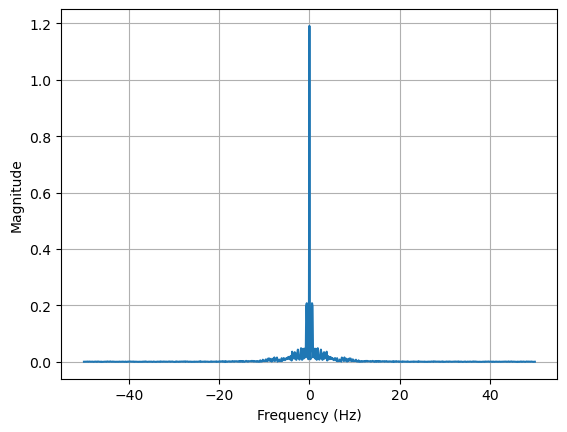

In [17]:
# Number of sample points
N, Ts = (863, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

yf = fft(magnitude)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid();

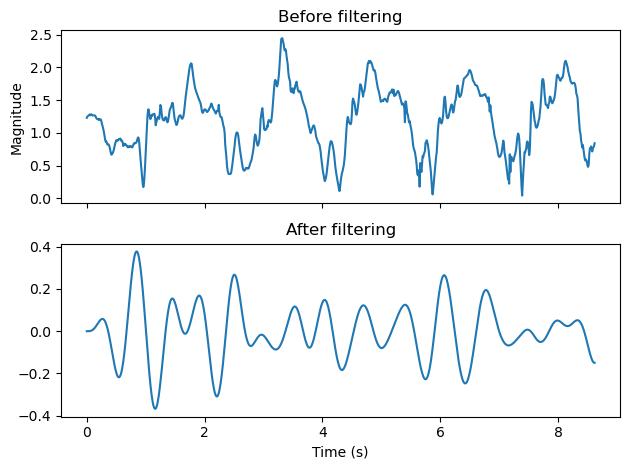

In [18]:
sig = magnitude # signal from before
sos = signal.butter(4, [1, 2], 'bandpass', fs=100, output='sos')
filtered = signal.sosfilt(sos, sig) # filtered signal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, sig)
ax1.set_title('Before filtering')
ax1.set_ylabel('Magnitude')

ax2.plot(t, filtered)
ax2.set_title('After filtering')
ax1.set_ylabel('Magnitude')

ax2.set_xlabel('Time (s)')
plt.tight_layout();

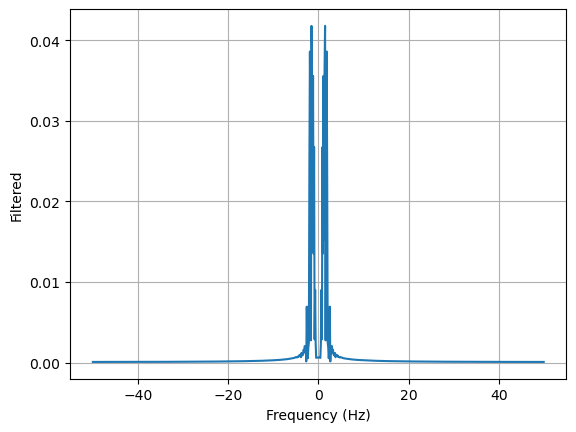

In [19]:
# Number of sample points
N, Ts = (863, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

yf = fft(filtered)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filtered')
plt.grid();

In [20]:
# Assume filtered_data is your filtered signal
# Define a threshold value for the peak. You may need to adjust this based on your signal characteristics.
threshold = 0.17  # Example threshold value, adjust as needed

peak_count = 0
above_threshold = False

for value in filtered:
    if value > threshold and not above_threshold:
        # Signal crosses above the threshold
        above_threshold = True
    elif value < threshold and above_threshold:
        # Signal drops below the threshold after being above it
        peak_count += 1
        above_threshold = False

print("Number of peaks:", peak_count)

Number of peaks: 4


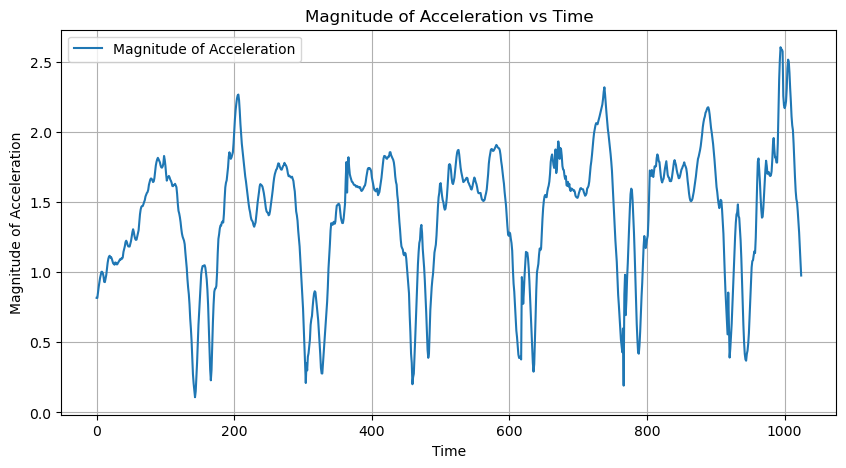

In [21]:


# Initialize three empty lists to store the values from each column
column1 = []
column2 = []
column3 = []

# Read the data from the file or use it as a string directly
data = """

0.42	0.70	-0.02
0.40	0.71	-0.04
0.41	0.75	-0.07
0.43	0.78	-0.08
0.45	0.81	-0.06
0.46	0.84	-0.05
0.47	0.86	-0.03
0.48	0.88	-0.01
0.48	0.88	-0.00
0.46	0.88	-0.00
0.43	0.87	0.00
0.38	0.85	-0.00
0.35	0.86	-0.02
0.34	0.89	-0.06
0.35	0.91	-0.10
0.37	0.95	-0.12
0.38	0.99	-0.11
0.39	1.02	-0.08
0.39	1.04	-0.04
0.38	1.05	-0.01
0.37	1.04	0.01
0.35	1.05	0.04
0.31	1.05	0.05
0.28	1.04	0.06
0.26	1.03	0.04
0.24	1.03	0.01
0.22	1.03	-0.00
0.20	1.05	-0.02
0.19	1.05	-0.03
0.18	1.04	-0.03
0.18	1.04	-0.03
0.18	1.05	-0.03
0.17	1.06	-0.01
0.16	1.07	0.01
0.16	1.08	0.02
0.14	1.08	0.03
0.13	1.09	0.03
0.11	1.09	0.03
0.11	1.10	0.03
0.10	1.14	0.00
0.09	1.16	-0.03
0.09	1.18	-0.05
0.08	1.21	-0.06
0.07	1.22	-0.07
0.06	1.21	-0.07
0.07	1.19	-0.07
0.07	1.18	-0.06
0.07	1.18	-0.04
0.07	1.18	-0.04
0.07	1.20	-0.03
0.07	1.22	-0.03
0.08	1.25	-0.05
0.09	1.28	-0.06
0.10	1.30	-0.07
0.10	1.28	-0.09
0.11	1.25	-0.09
0.11	1.23	-0.09
0.12	1.22	-0.10
0.13	1.22	-0.11
0.16	1.24	-0.11
0.20	1.26	-0.11
0.25	1.27	-0.10
0.32	1.31	-0.11
0.39	1.35	-0.14
0.44	1.37	-0.15
0.47	1.38	-0.15
0.49	1.38	-0.14
0.49	1.38	-0.14
0.50	1.39	-0.14
0.52	1.40	-0.14
0.53	1.41	-0.14
0.53	1.44	-0.12
0.52	1.46	-0.09
0.50	1.48	-0.08
0.46	1.50	-0.07
0.41	1.53	-0.10
0.38	1.57	-0.15
0.35	1.59	-0.21
0.32	1.61	-0.25
0.28	1.62	-0.28
0.24	1.62	-0.30
0.21	1.61	-0.32
0.20	1.60	-0.31
0.19	1.61	-0.29
0.19	1.64	-0.26
0.20	1.69	-0.21
0.21	1.74	-0.15
0.21	1.77	-0.10
0.21	1.79	-0.06
0.23	1.80	-0.00
0.23	1.79	0.03
0.21	1.78	0.06
0.19	1.77	0.08
0.15	1.75	0.10
0.10	1.74	0.11
0.05	1.74	0.12
-0.01	1.75	0.12
-0.08	1.77	0.12
-0.12	1.82	0.12
-0.12	1.79	0.15
-0.16	1.74	0.18
-0.16	1.67	0.26
-0.13	1.64	0.15
-0.15	1.65	0.21
-0.13	1.66	0.21
-0.11	1.67	0.20
-0.11	1.66	0.20
-0.11	1.64	0.23
-0.10	1.63	0.24
-0.08	1.62	0.22
-0.05	1.60	0.21
-0.02	1.60	0.20
0.00	1.61	0.19
0.04	1.61	0.20
0.07	1.62	0.16
0.10	1.61	0.11
0.11	1.60	0.08
0.13	1.55	0.05
0.13	1.48	0.05
0.13	1.43	0.05
0.15	1.41	0.03
0.18	1.38	0.01
0.21	1.34	-0.03
0.23	1.29	-0.04
0.24	1.25	-0.07
0.26	1.22	-0.11
0.28	1.20	-0.11
0.28	1.19	-0.07
0.26	1.17	-0.03
0.25	1.11	-0.01
0.24	1.06	0.00
0.24	1.00	-0.00
0.27	0.91	0.01
0.29	0.84	0.03
0.29	0.79	0.04
0.27	0.72	0.04
0.25	0.62	0.03
0.21	0.56	0.00
0.17	0.48	-0.02
0.11	0.37	-0.04
0.04	0.26	-0.07
-0.00	0.18	-0.10
-0.03	0.11	-0.11
-0.06	0.01	-0.09
-0.08	-0.10	-0.08
-0.11	-0.21	-0.07
-0.14	-0.32	-0.07
-0.20	-0.44	-0.07
-0.26	-0.56	-0.08
-0.28	-0.65	-0.09
-0.30	-0.74	-0.11
-0.28	-0.85	-0.15
-0.25	-0.94	-0.16
-0.24	-0.98	-0.16
-0.25	-1.00	-0.16
-0.26	-1.00	-0.14
-0.26	-1.01	-0.10
-0.27	-1.01	-0.09
-0.29	-0.99	-0.05
-0.32	-0.94	-0.03
-0.35	-0.88	-0.03
-0.37	-0.79	-0.04
-0.37	-0.67	-0.06
-0.33	-0.51	-0.07
-0.29	-0.34	-0.07
-0.25	-0.16	-0.08
-0.20	0.02	-0.11
-0.14	0.23	-0.14
-0.09	0.43	-0.21
-0.05	0.59	-0.25
-0.02	0.71	-0.30
0.01	0.79	-0.34
0.03	0.80	-0.37
0.02	0.82	-0.33
-0.01	0.85	-0.30
0.00	0.94	-0.31
0.06	1.06	-0.40
0.10	1.14	-0.47
0.11	1.17	-0.48
0.12	1.21	-0.49
0.10	1.25	-0.45
0.04	1.27	-0.40
0.04	1.30	-0.38
0.01	1.31	-0.37
-0.02	1.31	-0.34
-0.03	1.37	-0.35
0.00	1.46	-0.42
0.01	1.54	-0.45
-0.00	1.58	-0.43
0.00	1.61	-0.38
0.00	1.67	-0.34
-0.05	1.72	-0.30
-0.08	1.79	-0.32
-0.05	1.81	-0.40
-0.06	1.78	-0.42
-0.10	1.76	-0.40
-0.11	1.76	-0.44
-0.15	1.77	-0.46
-0.20	1.79	-0.44
-0.22	1.86	-0.41
-0.22	1.96	-0.38
-0.21	2.05	-0.35
-0.18	2.12	-0.33
-0.15	2.17	-0.33
-0.10	2.21	-0.34
-0.07	2.23	-0.36
-0.01	2.23	-0.40
0.03	2.19	-0.40
0.06	2.12	-0.35
0.10	2.03	-0.31
0.14	1.96	-0.28
0.19	1.89	-0.25
0.23	1.84	-0.23
0.27	1.79	-0.21
0.30	1.74	-0.19
0.34	1.68	-0.19
0.37	1.63	-0.18
0.39	1.59	-0.19
0.41	1.54	-0.20
0.40	1.50	-0.17
0.41	1.46	-0.18
0.40	1.42	-0.16
0.39	1.39	-0.14
0.38	1.37	-0.13
0.37	1.34	-0.12
0.36	1.32	-0.12
0.37	1.31	-0.12
0.37	1.30	-0.12
0.36	1.28	-0.12
0.35	1.27	-0.13
0.33	1.29	-0.14
0.31	1.31	-0.15
0.29	1.36	-0.15
0.28	1.41	-0.15
0.28	1.46	-0.17
0.26	1.50	-0.18
0.24	1.54	-0.20
0.23	1.58	-0.23
0.23	1.59	-0.26
0.23	1.58	-0.28
0.24	1.57	-0.31
0.28	1.55	-0.33
0.30	1.52	-0.35
0.31	1.49	-0.36
0.31	1.45	-0.38
0.30	1.41	-0.38
0.26	1.38	-0.38
0.21	1.36	-0.40
0.15	1.36	-0.40
0.09	1.36	-0.41
0.02	1.35	-0.39
-0.05	1.36	-0.37
-0.12	1.39	-0.33
-0.19	1.43	-0.28
-0.24	1.47	-0.25
-0.27	1.51	-0.20
-0.28	1.55	-0.19
-0.28	1.60	-0.18
-0.27	1.64	-0.18
-0.25	1.67	-0.18
-0.23	1.69	-0.17
-0.19	1.71	-0.19
-0.15	1.72	-0.18
-0.11	1.74	-0.20
-0.08	1.76	-0.22
-0.05	1.76	-0.21
-0.03	1.74	-0.22
-0.00	1.73	-0.20
0.02	1.72	-0.20
0.05	1.72	-0.18
0.10	1.73	-0.20
0.13	1.74	-0.20
0.12	1.75	-0.17
0.11	1.77	-0.14
0.11	1.76	-0.11
0.08	1.76	-0.05
0.06	1.75	0.01
0.05	1.73	0.06
0.06	1.70	0.07
0.10	1.68	0.06
0.16	1.68	0.01
0.21	1.67	-0.04
0.22	1.66	-0.06
0.22	1.66	-0.08
0.23	1.66	-0.12
0.24	1.64	-0.16
0.24	1.62	-0.20
0.22	1.58	-0.20
0.19	1.55	-0.21
0.14	1.48	-0.19
0.09	1.42	-0.17
0.09	1.39	-0.19
0.09	1.35	-0.19
0.09	1.28	-0.17
0.07	1.23	-0.16
0.06	1.17	-0.17
0.05	1.08	-0.17
0.01	0.98	-0.16
-0.03	0.91	-0.16
-0.07	0.82	-0.14
-0.10	0.72	-0.14
-0.12	0.59	-0.09
-0.14	0.44	-0.07
-0.15	0.28	-0.07
-0.16	0.13	-0.04
-0.34	0.08	-0.01
-0.27	-0.05	0.12
-0.15	-0.14	-0.34
-0.17	-0.36	-0.14
-0.15	-0.43	-0.13
-0.10	-0.49	-0.14
-0.11	-0.58	-0.20
-0.10	-0.64	-0.14
-0.14	-0.67	-0.07
-0.16	-0.73	-0.10
-0.17	-0.78	-0.12
-0.19	-0.82	-0.10
-0.18	-0.84	-0.09
-0.19	-0.83	-0.10
-0.20	-0.78	-0.10
-0.22	-0.72	-0.10
-0.24	-0.66	-0.11
-0.26	-0.59	-0.13
-0.24	-0.50	-0.16
-0.22	-0.41	-0.19
-0.17	-0.31	-0.22
-0.12	-0.17	-0.24
-0.08	-0.06	-0.26
-0.04	0.05	-0.27
-0.01	0.18	-0.30
0.00	0.29	-0.31
-0.00	0.38	-0.33
-0.01	0.46	-0.33
-0.00	0.54	-0.36
-0.00	0.62	-0.36
0.00	0.70	-0.36
0.02	0.81	-0.37
0.05	0.94	-0.41
0.08	1.02	-0.43
0.10	1.11	-0.43
0.14	1.20	-0.47
0.18	1.24	-0.50
0.21	1.24	-0.47
0.22	1.24	-0.45
0.23	1.26	-0.44
0.24	1.27	-0.42
0.24	1.27	-0.37
0.25	1.29	-0.35
0.28	1.34	-0.40
0.29	1.38	-0.43
0.29	1.39	-0.41
0.29	1.40	-0.40
0.29	1.40	-0.41
0.28	1.39	-0.42
0.24	1.36	-0.38
0.21	1.33	-0.34
0.17	1.32	-0.31
0.13	1.32	-0.25
0.10	1.33	-0.21
0.01	1.37	-0.17
0.05	1.42	-0.18
0.05	1.48	-0.13
0.08	1.63	-0.27
0.12	1.76	-0.27
-0.24	1.53	0.24
0.13	1.71	-0.39
0.10	1.78	-0.36
0.22	1.69	-0.39
0.05	1.69	-0.15
0.02	1.67	-0.15
0.11	1.64	-0.24
0.12	1.63	-0.18
0.12	1.63	-0.15
0.13	1.62	-0.15
0.13	1.61	-0.15
0.12	1.61	-0.14
0.11	1.61	-0.14
0.11	1.60	-0.13
0.12	1.60	-0.13
0.14	1.60	-0.15
0.15	1.59	-0.16
0.16	1.59	-0.17
0.18	1.58	-0.19
0.20	1.58	-0.20
0.21	1.56	-0.20
0.22	1.55	-0.20
0.25	1.55	-0.20
0.29	1.55	-0.21
0.34	1.55	-0.21
0.38	1.55	-0.23
0.40	1.55	-0.23
0.41	1.57	-0.24
0.43	1.60	-0.26
0.45	1.62	-0.28
0.47	1.64	-0.31
0.48	1.64	-0.34
0.47	1.63	-0.37
0.47	1.63	-0.39
0.46	1.62	-0.41
0.47	1.60	-0.42
0.48	1.55	-0.42
0.50	1.51	-0.44
0.52	1.47	-0.46
0.52	1.44	-0.46
0.50	1.43	-0.46
0.47	1.44	-0.46
0.42	1.45	-0.45
0.35	1.49	-0.44
0.27	1.52	-0.40
0.16	1.50	-0.35
0.12	1.53	-0.28
0.09	1.55	-0.24
0.04	1.59	-0.21
-0.03	1.62	-0.21
-0.04	1.66	-0.20
-0.01	1.71	-0.22
0.02	1.75	-0.25
0.04	1.79	-0.27
0.06	1.81	-0.25
0.06	1.81	-0.24
0.07	1.81	-0.20
0.08	1.80	-0.18
0.07	1.80	-0.15
0.07	1.81	-0.13
0.07	1.82	-0.10
0.05	1.82	-0.09
0.05	1.85	-0.11
0.07	1.85	-0.12
0.06	1.83	-0.11
0.02	1.82	-0.08
-0.01	1.81	-0.07
-0.05	1.80	-0.05
-0.05	1.78	-0.06
-0.02	1.74	-0.09
-0.03	1.68	-0.08
0.02	1.64	-0.11
0.06	1.62	-0.09
-0.01	1.55	-0.05
0.02	1.50	-0.15
0.03	1.43	-0.07
0.02	1.36	-0.04
0.04	1.30	-0.06
0.06	1.23	-0.04
0.09	1.18	-0.04
0.14	1.16	-0.08
0.20	1.14	-0.09
0.24	1.10	-0.07
0.28	1.08	-0.10
0.33	1.08	-0.14
0.37	1.06	-0.15
0.38	1.02	-0.14
0.38	0.96	-0.11
0.36	0.90	-0.08
0.34	0.84	-0.09
0.34	0.77	-0.11
0.23	0.65	-0.06
0.17	0.53	-0.13
0.07	0.41	-0.05
0.08	0.31	-0.15
-0.09	0.18	-0.00
-0.19	0.07	-0.15
-0.23	-0.06	-0.14
-0.31	-0.19	-0.15
-0.38	-0.32	-0.16
-0.43	-0.46	-0.19
-0.46	-0.61	-0.22
-0.49	-0.77	-0.21
-0.51	-0.90	-0.22
-0.51	-1.00	-0.22
-0.52	-1.07	-0.21
-0.41	-1.12	-0.30
-0.55	-1.19	-0.03
-0.55	-1.20	-0.21
-0.47	-1.17	-0.22
-0.44	-1.06	-0.20
-0.48	-0.98	-0.15
-0.49	-0.89	-0.18
-0.51	-0.78	-0.12
-0.50	-0.64	-0.16
-0.46	-0.51	-0.20
-0.41	-0.34	-0.21
-0.34	-0.16	-0.24
-0.28	0.02	-0.27
-0.22	0.19	-0.30
-0.15	0.38	-0.42
-0.10	0.54	-0.48
-0.06	0.66	-0.48
-0.01	0.76	-0.47
0.03	0.84	-0.44
0.06	0.90	-0.41
0.09	0.98	-0.41
0.12	1.06	-0.40
0.13	1.10	-0.37
0.12	1.14	-0.34
0.12	1.21	-0.34
0.14	1.30	-0.38
0.18	1.37	-0.47
0.21	1.42	-0.54
0.22	1.46	-0.52
0.23	1.53	-0.50
0.24	1.55	-0.46
0.23	1.53	-0.37
0.22	1.50	-0.30
0.20	1.48	-0.24
0.18	1.47	-0.23
0.15	1.44	-0.21
0.12	1.42	-0.24
0.11	1.42	-0.28
0.10	1.45	-0.30
0.11	1.50	-0.30
0.13	1.57	-0.30
0.18	1.65	-0.32
0.21	1.72	-0.33
0.21	1.73	-0.31
0.18	1.73	-0.28
0.12	1.70	-0.28
0.03	1.65	-0.25
-0.08	1.62	-0.21
-0.16	1.61	-0.18
-0.25	1.62	-0.16
-0.30	1.64	-0.14
-0.34	1.68	-0.15
-0.35	1.73	-0.17
-0.31	1.78	-0.21
-0.26	1.82	-0.24
-0.18	1.84	-0.27
-0.11	1.84	-0.32
-0.03	1.81	-0.32
0.04	1.76	-0.31
0.09	1.72	-0.28
0.13	1.69	-0.25
0.17	1.66	-0.26
0.18	1.63	-0.26
0.19	1.61	-0.26
0.20	1.61	-0.28
0.23	1.61	-0.30
0.26	1.60	-0.34
0.28	1.60	-0.38
0.28	1.60	-0.40
0.27	1.59	-0.43
0.27	1.56	-0.43
0.29	1.54	-0.46
0.30	1.52	-0.47
0.32	1.50	-0.49
0.33	1.48	-0.49
0.35	1.47	-0.49
0.37	1.48	-0.50
0.39	1.50	-0.51
0.41	1.51	-0.54
0.41	1.52	-0.57
0.39	1.51	-0.57
0.37	1.49	-0.58
0.35	1.48	-0.58
0.33	1.46	-0.58
0.34	1.43	-0.57
0.36	1.41	-0.57
0.40	1.40	-0.57
0.43	1.39	-0.57
0.45	1.39	-0.56
0.44	1.38	-0.52
0.41	1.38	-0.48
0.37	1.40	-0.44
0.32	1.42	-0.39
0.25	1.45	-0.34
0.18	1.48	-0.28
0.09	1.52	-0.25
0.01	1.55	-0.20
-0.07	1.58	-0.16
-0.15	1.63	-0.13
-0.22	1.68	-0.10
-0.26	1.75	-0.11
-0.27	1.79	-0.13
-0.28	1.82	-0.12
-0.25	1.85	-0.14
-0.20	1.86	-0.16
-0.14	1.86	-0.19
-0.08	1.85	-0.21
-0.04	1.85	-0.24
-0.02	1.86	-0.23
-0.02	1.87	-0.24
-0.02	1.88	-0.24
-0.03	1.89	-0.25
-0.02	1.88	-0.27
-0.01	1.87	-0.27
0.03	1.86	-0.30
0.08	1.85	-0.34
0.11	1.83	-0.36
0.10	1.80	-0.35
0.07	1.76	-0.32
0.05	1.73	-0.30
0.05	1.69	-0.26
0.07	1.65	-0.24
0.09	1.61	-0.24
0.12	1.55	-0.22
0.15	1.50	-0.22
0.16	1.45	-0.22
0.20	1.37	-0.19
0.24	1.30	-0.14
0.22	1.24	-0.16
0.17	1.22	-0.26
0.17	1.23	-0.32
0.20	1.21	-0.35
0.22	1.17	-0.34
0.22	1.14	-0.33
0.21	1.06	-0.40
0.18	0.96	-0.30
0.14	0.87	-0.26
0.11	0.81	-0.27
0.06	0.73	-0.23
0.01	0.64	-0.20
-0.05	0.55	-0.19
-0.11	0.49	-0.19
-0.17	0.41	-0.18
-0.24	0.30	-0.15
-0.30	0.21	-0.13
-0.37	0.10	-0.10
-0.35	-0.10	-0.16
-0.21	-0.19	-0.25
-0.83	-0.30	0.39
-0.55	-0.46	-0.54
-0.36	-0.68	-0.09
-0.36	-0.79	0.02
-0.32	-0.92	-0.10
-0.34	-1.01	0.04
-0.37	-1.08	-0.08
-0.29	-1.10	-0.06
-0.29	-1.10	-0.04
-0.32	-1.05	-0.02
-0.37	-0.96	0.00
-0.41	-0.84	0.01
-0.42	-0.70	0.00
-0.40	-0.57	0.01
-0.38	-0.43	-0.01
-0.36	-0.29	-0.03
-0.32	-0.14	-0.05
-0.27	0.04	-0.10
-0.21	0.22	-0.16
-0.15	0.40	-0.27
-0.08	0.56	-0.38
-0.02	0.72	-0.49
0.02	0.84	-0.54
0.04	0.89	-0.51
0.07	0.93	-0.50
0.06	1.00	-0.51
0.05	1.06	-0.49
0.02	1.07	-0.44
0.00	1.10	-0.40
0.01	1.20	-0.43
0.02	1.30	-0.46
0.03	1.38	-0.47
0.04	1.43	-0.48
0.04	1.46	-0.49
0.04	1.46	-0.52
0.03	1.45	-0.51
0.00	1.46	-0.47
-0.01	1.51	-0.44
-0.02	1.55	-0.39
-0.01	1.58	-0.34
-0.03	1.62	-0.29
-0.02	1.68	-0.27
0.02	1.76	-0.30
0.06	1.79	-0.33
0.11	1.80	-0.36
0.13	1.76	-0.38
0.10	1.72	-0.38
0.05	1.70	-0.38
0.01	1.71	-0.39
0.15	1.72	-0.73
-0.23	1.69	0.04
-0.09	1.67	-0.48
-0.01	1.82	-0.40
0.13	1.85	-0.54
-0.01	1.86	-0.36
-0.14	1.78	-0.28
-0.01	1.80	-0.56
0.09	1.80	-0.52
0.09	1.76	-0.49
0.08	1.69	-0.47
0.11	1.66	-0.48
0.14	1.66	-0.46
0.13	1.62	-0.45
0.15	1.60	-0.43
0.21	1.62	-0.41
0.24	1.55	-0.40
0.28	1.54	-0.40
0.35	1.55	-0.42
0.37	1.51	-0.42
0.40	1.52	-0.43
0.40	1.47	-0.45
0.38	1.47	-0.43
0.40	1.49	-0.41
0.38	1.48	-0.45
0.36	1.48	-0.45
0.36	1.47	-0.46
0.37	1.46	-0.49
0.37	1.44	-0.51
0.37	1.41	-0.51
0.36	1.40	-0.52
0.34	1.40	-0.52
0.33	1.40	-0.52
0.32	1.42	-0.51
0.32	1.44	-0.52
0.33	1.45	-0.53
0.34	1.46	-0.55
0.35	1.46	-0.55
0.36	1.45	-0.55
0.38	1.44	-0.56
0.42	1.42	-0.58
0.45	1.39	-0.58
0.46	1.37	-0.58
0.46	1.36	-0.57
0.46	1.37	-0.56
0.47	1.38	-0.56
0.47	1.42	-0.56
0.44	1.44	-0.55
0.39	1.48	-0.52
0.34	1.53	-0.50
0.28	1.60	-0.49
0.23	1.68	-0.45
0.17	1.73	-0.43
0.14	1.79	-0.39
0.13	1.85	-0.39
0.12	1.91	-0.36
0.11	1.96	-0.34
0.10	1.99	-0.32
0.11	2.02	-0.31
0.11	2.04	-0.28
0.10	2.04	-0.26
0.09	2.04	-0.22
0.07	2.06	-0.21
0.06	2.08	-0.19
0.06	2.10	-0.20
0.07	2.12	-0.21
0.08	2.14	-0.22
0.10	2.16	-0.24
0.17	2.17	-0.28
0.23	2.20	-0.31
0.29	2.24	-0.35
0.32	2.26	-0.40
0.25	2.22	-0.37
0.12	2.17	-0.31
-0.01	2.12	-0.25
-0.09	2.06	-0.21
-0.10	2.01	-0.18
-0.03	1.97	-0.21
0.03	1.92	-0.24
0.09	1.86	-0.27
0.14	1.81	-0.31
0.14	1.75	-0.33
0.13	1.68	-0.35
0.09	1.58	-0.35
0.04	1.48	-0.33
0.02	1.40	-0.32
-0.00	1.30	-0.30
-0.04	1.20	-0.24
-0.03	1.12	-0.25
-0.03	1.04	-0.26
-0.09	0.92	-0.23
-0.16	0.80	-0.19
-0.23	0.71	-0.17
-0.26	0.61	-0.15
-0.30	0.50	-0.13
-0.34	0.38	-0.10
-0.37	0.27	-0.12
-0.38	0.16	-0.12
-0.59	0.01	-0.10
-0.14	-0.01	-0.13
-0.81	-0.17	0.14
-0.69	-0.30	-0.63
-0.51	-0.47	-0.01
-0.55	-0.56	-0.17
-0.66	-0.69	-0.09
-0.72	-0.77	-0.15
-0.76	-0.92	-0.19
-0.72	-1.09	-0.25
-0.68	-1.27	-0.19
-0.67	-1.39	-0.20
-0.65	-1.44	-0.22
-0.64	-1.43	-0.23
-0.62	-1.36	-0.21
-0.63	-1.24	-0.18
-0.65	-1.09	-0.16
-0.63	-0.93	-0.13
-0.58	-0.75	-0.12
-0.53	-0.57	-0.12
-0.48	-0.39	-0.12
-0.46	-0.22	-0.09
-0.40	-0.04	-0.14
-0.36	0.13	-0.17
-0.31	0.29	-0.22
-0.27	0.43	-0.27
-0.24	0.55	-0.38
-0.19	0.68	-0.43
-0.14	0.79	-0.46
-0.10	0.91	-0.51
-0.03	1.02	-0.60
0.02	1.07	-0.66
0.01	1.06	-0.59
0.02	1.05	-0.52
0.00	1.09	-0.50
0.00	1.14	-0.48
0.00	1.18	-0.44
0.03	1.29	-0.46
0.14	1.44	-0.58
0.26	1.55	-0.71
0.30	1.54	-0.69
0.34	1.53	-0.62
0.39	1.54	-0.68
0.37	1.54	-0.63
0.35	1.55	-0.54
0.37	1.59	-0.52
0.39	1.63	-0.52
0.38	1.64	-0.49
0.38	1.65	-0.46
0.43	1.68	-0.53
0.46	1.68	-0.59
0.46	1.66	-0.60
0.43	1.63	-0.60
0.39	1.64	-0.59
0.33	1.61	-0.55
0.27	1.59	-0.49
0.21	1.58	-0.44
0.15	1.58	-0.41
0.10	1.61	-0.38
0.05	1.63	-0.34
0.03	1.67	-0.33
0.05	1.70	-0.36
0.09	1.72	-0.38
0.14	1.73	-0.44
0.15	1.68	-0.44
0.14	1.64	-0.40
0.14	1.62	-0.41
0.13	1.62	-0.40
0.13	1.60	-0.38
0.14	1.60	-0.37
0.15	1.60	-0.37
0.16	1.62	-0.37
0.18	1.65	-0.39
0.21	1.68	-0.41
0.26	1.70	-0.46
0.29	1.70	-0.51
0.32	1.67	-0.53
0.34	1.64	-0.55
0.36	1.60	-0.55
0.38	1.57	-0.55
0.40	1.55	-0.54
0.43	1.53	-0.51
0.46	1.53	-0.49
0.48	1.54	-0.49
0.50	1.56	-0.49
0.50	1.58	-0.50
0.49	1.59	-0.51
0.51	1.59	-0.54
0.53	1.59	-0.55
0.56	1.59	-0.58
0.60	1.55	-0.59
0.65	1.51	-0.61
0.69	1.47	-0.62
0.72	1.41	-0.63
0.72	1.35	-0.62
0.71	1.31	-0.61
0.68	1.28	-0.58
0.64	1.27	-0.56
0.59	1.28	-0.54
0.54	1.31	-0.51
0.48	1.35	-0.48
0.41	1.40	-0.44
0.35	1.45	-0.42
0.30	1.50	-0.38
0.26	1.55	-0.36
0.22	1.60	-0.35
0.18	1.64	-0.33
0.15	1.69	-0.33
0.14	1.73	-0.33
0.13	1.77	-0.34
0.13	1.79	-0.32
0.16	1.81	-0.33
0.19	1.83	-0.33
0.21	1.86	-0.32
0.23	1.90	-0.32
0.26	1.94	-0.31
0.27	1.99	-0.32
0.24	2.03	-0.31
0.22	2.06	-0.30
0.18	2.08	-0.30
0.15	2.11	-0.30
0.14	2.12	-0.30
0.15	2.13	-0.34
0.14	2.14	-0.35
0.12	2.14	-0.37
0.09	2.13	-0.33
0.07	2.10	-0.30
0.06	2.05	-0.29
0.03	2.01	-0.26
0.01	1.98	-0.24
0.01	1.94	-0.23
0.01	1.90	-0.22
-0.00	1.85	-0.20
0.00	1.79	-0.21
0.03	1.72	-0.25
0.04	1.65	-0.25
0.04	1.59	-0.23
0.07	1.55	-0.25
0.10	1.50	-0.24
0.14	1.46	-0.23
0.18	1.43	-0.21
0.25	1.45	-0.23
0.34	1.45	-0.28
0.36	1.44	-0.27
0.33	1.39	-0.22
0.31	1.31	-0.21
0.27	1.23	-0.19
0.15	1.10	-0.14
0.03	0.98	-0.10
-0.07	0.85	-0.09
-0.17	0.73	-0.07
-0.35	0.53	-0.05
-0.13	0.53	0.11
-0.76	0.38	0.09
-0.55	0.18	-0.24
-0.39	-0.01	-0.03
-0.44	-0.11	-0.05
-0.49	-0.25	0.04
-0.52	-0.36	-0.01
-0.55	-0.52	0.05
-0.55	-0.69	0.04
-0.56	-0.85	0.06
-0.58	-0.96	0.10
-0.65	-1.07	0.10
-0.70	-1.15	0.13
-0.76	-1.18	0.14
-0.82	-1.16	0.12
-0.89	-1.18	0.12
-0.72	-1.20	0.05
-0.83	-1.11	0.03
-0.75	-1.06	0.04
-0.72	-0.99	0.02
-0.66	-0.88	-0.03
-0.59	-0.73	-0.05
-0.50	-0.59	-0.10
-0.43	-0.44	-0.11
-0.39	-0.28	-0.15
-0.35	-0.14	-0.18
-0.32	-0.03	-0.20
-0.29	0.06	-0.22
-0.27	0.15	-0.28
-0.26	0.23	-0.27
-0.23	0.32	-0.29
-0.20	0.41	-0.33
-0.16	0.53	-0.39
-0.12	0.64	-0.42
-0.07	0.77	-0.44
0.02	0.90	-0.51
0.05	0.96	-0.49
0.07	0.98	-0.46
0.12	1.01	-0.47
0.16	1.04	-0.46
0.19	1.05	-0.39
0.28	1.15	-0.39
0.37	1.31	-0.47
0.47	1.47	-0.52
0.62	1.57	-0.59
0.71	1.52	-0.68
0.69	1.46	-0.61
0.68	1.35	-0.65
0.59	1.29	-0.59
0.51	1.25	-0.52
0.47	1.23	-0.44
0.47	1.26	-0.37
0.49	1.33	-0.34
0.51	1.43	-0.30
0.57	1.50	-0.32
0.64	1.56	-0.39
0.71	1.57	-0.50
0.71	1.51	-0.55
0.70	1.46	-0.52
0.71	1.47	-0.51
0.73	1.47	-0.49
0.73	1.46	-0.44
0.72	1.47	-0.40
0.71	1.49	-0.36
0.75	1.51	-0.33
0.85	1.55	-0.33
1.00	1.59	-0.36
1.13	1.54	-0.42
1.10	1.46	-0.42
1.02	1.45	-0.40
0.97	1.47	-0.45
0.92	1.47	-0.41
0.93	1.48	-0.34
1.05	1.58	-0.26
1.27	1.73	-0.14
1.51	1.83	0.02
1.63	1.91	-0.03
1.71	1.96	-0.10
1.70	1.95	-0.08
1.59	2.04	0.01
1.52	2.05	-0.33
1.32	1.83	-0.01
1.27	1.78	-0.09
1.21	1.80	-0.01
1.21	1.82	0.02
1.20	1.86	0.13
1.19	1.97	0.16
1.24	2.11	0.17
1.23	2.19	0.12
1.12	2.23	0.13
1.00	2.18	0.32
0.89	2.11	0.30
0.81	2.02	0.43
0.68	1.94	0.48
0.55	1.93	0.40
0.52	1.90	0.41
0.41	1.83	0.39
0.30	1.74	0.33
0.20	1.63	0.34
0.19	1.53	0.34
0.11	1.49	0.28
0.04	1.46	0.33
-0.04	1.40	  0.31
-0.15	1.33	  0.23
-0.24	1.25	  0.17
-0.30	1.13	  0.09
-0.34	1.02	  0.05
-0.32	0.92	  0.06


"""

# Split the data into lines and iterate through each line
for line in data.strip().split('\n'):
    # Split each line into three values using whitespace as the delimiter
    values = line.split()
    
    # Convert each value to float and append it to the corresponding list
    column1.append(float(values[0]))
    column2.append(float(values[1]))
    column3.append(float(values[2]))

# Calculating the magnitude of acceleration at each point in time
magnitude = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in zip(column1, column2, column3)]

# Creating a time array
time = range(len(column1))

# Plotting the magnitude of acceleration against time
plt.figure(figsize=(10, 5))
plt.plot(time, magnitude, label='Magnitude of Acceleration')
plt.xlabel('Time')
plt.ylabel('Magnitude of Acceleration')
plt.title('Magnitude of Acceleration vs Time')
plt.legend()
plt.grid(True)
plt.show()

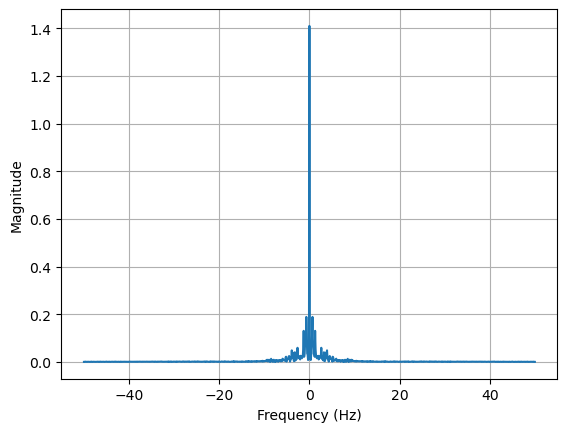

In [22]:
# Number of sample points
N, Ts = (1025, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

yf = fft(magnitude)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid();

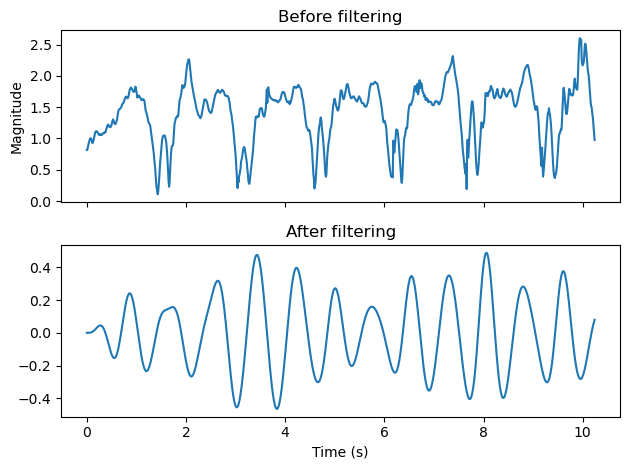

In [23]:
sig = magnitude # signal from before
sos = signal.butter(4, [1, 2], 'bandpass', fs=100, output='sos')
filtered = signal.sosfilt(sos, sig) # filtered signal

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(t, sig)
ax1.set_title('Before filtering')
ax1.set_ylabel('Magnitude')

ax2.plot(t, filtered)
ax2.set_title('After filtering')
ax1.set_ylabel('Magnitude')

ax2.set_xlabel('Time (s)')
plt.tight_layout();

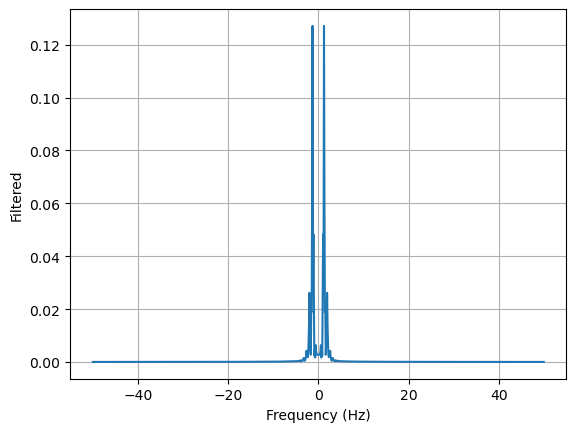

In [24]:
# Number of sample points
N, Ts = (1025, 1/100)

t = np.linspace(0.0, N*Ts, N, endpoint=False)

yf = fft(filtered)
xf = fftfreq(N, Ts)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filtered')
plt.grid();

In [25]:
# Assume filtered_data is your filtered signal
# Define a threshold value for the peak. You may need to adjust this based on your signal characteristics.
threshold = 0.17  # Example threshold value, adjust as needed

peak_count = 0
above_threshold = False

for value in filtered:
    if value > threshold and not above_threshold:
        # Signal crosses above the threshold
        above_threshold = True
    elif value < threshold and above_threshold:
        # Signal drops below the threshold after being above it
        peak_count += 1
        above_threshold = False

print("Number of peaks:", peak_count)

Number of peaks: 10


In [26]:
#function to count peaks with raw data

def count_peaks(data):
    above_threshold = threshhold = 0.17
    # Initialize lists to store the values
    column1, column2, column3 = [], [], []

    # Parse the input data
    for line in data.strip().split('\n'):
        values = line.split()
        column1.append(float(values[0]))
        column2.append(float(values[1]))
        column3.append(float(values[2]))

    # Calculate the magnitude of acceleration
    magnitude = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in zip(column1, column2, column3)]

    # Signal processing
    fs = 100  # Sampling frequency
    sos = signal.butter(4, [1, 2], 'bandpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, magnitude)  # Apply bandpass filter

    # Count peaks
    peak_count = 0
    above_threshold = False
    for value in filtered:
        if value > threshold and not above_threshold:
            # Signal crosses above the threshold
            above_threshold = True
        elif value < threshold and above_threshold:
            # Signal drops below the threshold after being above it
            peak_count += 1
            above_threshold = False

    return peak_count

In [27]:
# Example usage
data = """
0.42	0.70	-0.02
0.40	0.71	-0.04
0.41	0.75	-0.07
0.43	0.78	-0.08
0.45	0.81	-0.06
0.46	0.84	-0.05
0.47	0.86	-0.03
0.48	0.88	-0.01
0.48	0.88	-0.00
0.46	0.88	-0.00
0.43	0.87	0.00
0.38	0.85	-0.00
0.35	0.86	-0.02
0.34	0.89	-0.06
0.35	0.91	-0.10
0.37	0.95	-0.12
0.38	0.99	-0.11
0.39	1.02	-0.08
0.39	1.04	-0.04
0.38	1.05	-0.01
0.37	1.04	0.01
0.35	1.05	0.04
0.31	1.05	0.05
0.28	1.04	0.06
0.26	1.03	0.04
0.24	1.03	0.01
0.22	1.03	-0.00
0.20	1.05	-0.02
0.19	1.05	-0.03
0.18	1.04	-0.03
0.18	1.04	-0.03
0.18	1.05	-0.03
0.17	1.06	-0.01
0.16	1.07	0.01
0.16	1.08	0.02
0.14	1.08	0.03
0.13	1.09	0.03
0.11	1.09	0.03
0.11	1.10	0.03
0.10	1.14	0.00
0.09	1.16	-0.03
0.09	1.18	-0.05
0.08	1.21	-0.06
0.07	1.22	-0.07
0.06	1.21	-0.07
0.07	1.19	-0.07
0.07	1.18	-0.06
0.07	1.18	-0.04
0.07	1.18	-0.04
0.07	1.20	-0.03
0.07	1.22	-0.03
0.08	1.25	-0.05
0.09	1.28	-0.06
0.10	1.30	-0.07
0.10	1.28	-0.09
0.11	1.25	-0.09
0.11	1.23	-0.09
0.12	1.22	-0.10
0.13	1.22	-0.11
0.16	1.24	-0.11
0.20	1.26	-0.11
0.25	1.27	-0.10
0.32	1.31	-0.11
0.39	1.35	-0.14
0.44	1.37	-0.15
0.47	1.38	-0.15
0.49	1.38	-0.14
0.49	1.38	-0.14
0.50	1.39	-0.14
0.52	1.40	-0.14
0.53	1.41	-0.14
0.53	1.44	-0.12
0.52	1.46	-0.09
0.50	1.48	-0.08
0.46	1.50	-0.07
0.41	1.53	-0.10
0.38	1.57	-0.15
0.35	1.59	-0.21
0.32	1.61	-0.25
0.28	1.62	-0.28
0.24	1.62	-0.30
0.21	1.61	-0.32
0.20	1.60	-0.31
0.19	1.61	-0.29
0.19	1.64	-0.26
0.20	1.69	-0.21
0.21	1.74	-0.15
0.21	1.77	-0.10
0.21	1.79	-0.06
0.23	1.80	-0.00
0.23	1.79	0.03
0.21	1.78	0.06
0.19	1.77	0.08
0.15	1.75	0.10
0.10	1.74	0.11
0.05	1.74	0.12
-0.01	1.75	0.12
-0.08	1.77	0.12
-0.12	1.82	0.12
-0.12	1.79	0.15
-0.16	1.74	0.18
-0.16	1.67	0.26
-0.13	1.64	0.15
-0.15	1.65	0.21
-0.13	1.66	0.21
-0.11	1.67	0.20
-0.11	1.66	0.20
-0.11	1.64	0.23
-0.10	1.63	0.24
-0.08	1.62	0.22
-0.05	1.60	0.21
-0.02	1.60	0.20
0.00	1.61	0.19
0.04	1.61	0.20
0.07	1.62	0.16
0.10	1.61	0.11
0.11	1.60	0.08
0.13	1.55	0.05
0.13	1.48	0.05
0.13	1.43	0.05
0.15	1.41	0.03
0.18	1.38	0.01
0.21	1.34	-0.03
0.23	1.29	-0.04
0.24	1.25	-0.07
0.26	1.22	-0.11
0.28	1.20	-0.11
0.28	1.19	-0.07
0.26	1.17	-0.03
0.25	1.11	-0.01
0.24	1.06	0.00
0.24	1.00	-0.00
0.27	0.91	0.01
0.29	0.84	0.03
0.29	0.79	0.04
0.27	0.72	0.04
0.25	0.62	0.03
0.21	0.56	0.00
0.17	0.48	-0.02
0.11	0.37	-0.04
0.04	0.26	-0.07
-0.00	0.18	-0.10
-0.03	0.11	-0.11
-0.06	0.01	-0.09
-0.08	-0.10	-0.08
-0.11	-0.21	-0.07
-0.14	-0.32	-0.07
-0.20	-0.44	-0.07
-0.26	-0.56	-0.08
-0.28	-0.65	-0.09
-0.30	-0.74	-0.11
-0.28	-0.85	-0.15
-0.25	-0.94	-0.16
-0.24	-0.98	-0.16
-0.25	-1.00	-0.16
-0.26	-1.00	-0.14
-0.26	-1.01	-0.10
-0.27	-1.01	-0.09
-0.29	-0.99	-0.05
-0.32	-0.94	-0.03
-0.35	-0.88	-0.03
-0.37	-0.79	-0.04
-0.37	-0.67	-0.06
-0.33	-0.51	-0.07
-0.29	-0.34	-0.07
-0.25	-0.16	-0.08
-0.20	0.02	-0.11
-0.14	0.23	-0.14
-0.09	0.43	-0.21
-0.05	0.59	-0.25
-0.02	0.71	-0.30
0.01	0.79	-0.34
0.03	0.80	-0.37
0.02	0.82	-0.33
-0.01	0.85	-0.30
0.00	0.94	-0.31
0.06	1.06	-0.40
0.10	1.14	-0.47
0.11	1.17	-0.48
0.12	1.21	-0.49
0.10	1.25	-0.45
0.04	1.27	-0.40
0.04	1.30	-0.38
0.01	1.31	-0.37
-0.02	1.31	-0.34
-0.03	1.37	-0.35
0.00	1.46	-0.42
0.01	1.54	-0.45
-0.00	1.58	-0.43
0.00	1.61	-0.38
0.00	1.67	-0.34
-0.05	1.72	-0.30
-0.08	1.79	-0.32
-0.05	1.81	-0.40
-0.06	1.78	-0.42
-0.10	1.76	-0.40
-0.11	1.76	-0.44
-0.15	1.77	-0.46
-0.20	1.79	-0.44
-0.22	1.86	-0.41
-0.22	1.96	-0.38
-0.21	2.05	-0.35
-0.18	2.12	-0.33
-0.15	2.17	-0.33
-0.10	2.21	-0.34
-0.07	2.23	-0.36
-0.01	2.23	-0.40
0.03	2.19	-0.40
0.06	2.12	-0.35
0.10	2.03	-0.31
0.14	1.96	-0.28
0.19	1.89	-0.25
0.23	1.84	-0.23
0.27	1.79	-0.21
0.30	1.74	-0.19
0.34	1.68	-0.19
0.37	1.63	-0.18
0.39	1.59	-0.19
0.41	1.54	-0.20
0.40	1.50	-0.17
0.41	1.46	-0.18
0.40	1.42	-0.16
0.39	1.39	-0.14
0.38	1.37	-0.13
0.37	1.34	-0.12
0.36	1.32	-0.12
0.37	1.31	-0.12
0.37	1.30	-0.12
0.36	1.28	-0.12
0.35	1.27	-0.13
0.33	1.29	-0.14
0.31	1.31	-0.15
0.29	1.36	-0.15
0.28	1.41	-0.15
0.28	1.46	-0.17
0.26	1.50	-0.18
0.24	1.54	-0.20
0.23	1.58	-0.23
0.23	1.59	-0.26
0.23	1.58	-0.28
0.24	1.57	-0.31
0.28	1.55	-0.33
0.30	1.52	-0.35
0.31	1.49	-0.36
0.31	1.45	-0.38
0.30	1.41	-0.38
0.26	1.38	-0.38
0.21	1.36	-0.40
0.15	1.36	-0.40
0.09	1.36	-0.41
0.02	1.35	-0.39
-0.05	1.36	-0.37
-0.12	1.39	-0.33
-0.19	1.43	-0.28
-0.24	1.47	-0.25
-0.27	1.51	-0.20
-0.28	1.55	-0.19
-0.28	1.60	-0.18
-0.27	1.64	-0.18
-0.25	1.67	-0.18
-0.23	1.69	-0.17
-0.19	1.71	-0.19
-0.15	1.72	-0.18
-0.11	1.74	-0.20
-0.08	1.76	-0.22
-0.05	1.76	-0.21
-0.03	1.74	-0.22
-0.00	1.73	-0.20
0.02	1.72	-0.20
0.05	1.72	-0.18
0.10	1.73	-0.20
0.13	1.74	-0.20
0.12	1.75	-0.17
0.11	1.77	-0.14
0.11	1.76	-0.11
0.08	1.76	-0.05
0.06	1.75	0.01
0.05	1.73	0.06
0.06	1.70	0.07
0.10	1.68	0.06
0.16	1.68	0.01
0.21	1.67	-0.04
0.22	1.66	-0.06
0.22	1.66	-0.08
0.23	1.66	-0.12
0.24	1.64	-0.16
0.24	1.62	-0.20
0.22	1.58	-0.20
0.19	1.55	-0.21
0.14	1.48	-0.19
0.09	1.42	-0.17
0.09	1.39	-0.19
0.09	1.35	-0.19
0.09	1.28	-0.17
0.07	1.23	-0.16
0.06	1.17	-0.17
0.05	1.08	-0.17
0.01	0.98	-0.16
-0.03	0.91	-0.16
-0.07	0.82	-0.14
-0.10	0.72	-0.14
-0.12	0.59	-0.09
-0.14	0.44	-0.07
-0.15	0.28	-0.07
-0.16	0.13	-0.04
-0.34	0.08	-0.01
-0.27	-0.05	0.12
-0.15	-0.14	-0.34
-0.17	-0.36	-0.14
-0.15	-0.43	-0.13
-0.10	-0.49	-0.14
-0.11	-0.58	-0.20
-0.10	-0.64	-0.14
-0.14	-0.67	-0.07
-0.16	-0.73	-0.10
-0.17	-0.78	-0.12
-0.19	-0.82	-0.10
-0.18	-0.84	-0.09
-0.19	-0.83	-0.10
-0.20	-0.78	-0.10
-0.22	-0.72	-0.10
-0.24	-0.66	-0.11
-0.26	-0.59	-0.13
-0.24	-0.50	-0.16
-0.22	-0.41	-0.19
-0.17	-0.31	-0.22
-0.12	-0.17	-0.24
-0.08	-0.06	-0.26
-0.04	0.05	-0.27
-0.01	0.18	-0.30
0.00	0.29	-0.31
-0.00	0.38	-0.33
-0.01	0.46	-0.33
-0.00	0.54	-0.36
-0.00	0.62	-0.36
0.00	0.70	-0.36
0.02	0.81	-0.37
0.05	0.94	-0.41
0.08	1.02	-0.43
0.10	1.11	-0.43
0.14	1.20	-0.47
0.18	1.24	-0.50
0.21	1.24	-0.47
0.22	1.24	-0.45
0.23	1.26	-0.44
0.24	1.27	-0.42
0.24	1.27	-0.37
0.25	1.29	-0.35
0.28	1.34	-0.40
0.29	1.38	-0.43
0.29	1.39	-0.41
0.29	1.40	-0.40
0.29	1.40	-0.41
0.28	1.39	-0.42
0.24	1.36	-0.38
0.21	1.33	-0.34
0.17	1.32	-0.31
0.13	1.32	-0.25
0.10	1.33	-0.21
0.01	1.37	-0.17
0.05	1.42	-0.18
0.05	1.48	-0.13
0.08	1.63	-0.27
0.12	1.76	-0.27
-0.24	1.53	0.24
0.13	1.71	-0.39
0.10	1.78	-0.36
0.22	1.69	-0.39
0.05	1.69	-0.15
0.02	1.67	-0.15
0.11	1.64	-0.24
0.12	1.63	-0.18
0.12	1.63	-0.15
0.13	1.62	-0.15
0.13	1.61	-0.15
0.12	1.61	-0.14
0.11	1.61	-0.14
0.11	1.60	-0.13
0.12	1.60	-0.13
0.14	1.60	-0.15
0.15	1.59	-0.16
0.16	1.59	-0.17
0.18	1.58	-0.19
0.20	1.58	-0.20
0.21	1.56	-0.20
0.22	1.55	-0.20
0.25	1.55	-0.20
0.29	1.55	-0.21
0.34	1.55	-0.21
0.38	1.55	-0.23
0.40	1.55	-0.23
0.41	1.57	-0.24
0.43	1.60	-0.26
0.45	1.62	-0.28
0.47	1.64	-0.31
0.48	1.64	-0.34
0.47	1.63	-0.37
0.47	1.63	-0.39
0.46	1.62	-0.41
0.47	1.60	-0.42
0.48	1.55	-0.42
0.50	1.51	-0.44
0.52	1.47	-0.46
0.52	1.44	-0.46
0.50	1.43	-0.46
0.47	1.44	-0.46
0.42	1.45	-0.45
0.35	1.49	-0.44
0.27	1.52	-0.40
0.16	1.50	-0.35
0.12	1.53	-0.28
0.09	1.55	-0.24
0.04	1.59	-0.21
-0.03	1.62	-0.21
-0.04	1.66	-0.20
-0.01	1.71	-0.22
0.02	1.75	-0.25
0.04	1.79	-0.27
0.06	1.81	-0.25
0.06	1.81	-0.24
0.07	1.81	-0.20
0.08	1.80	-0.18
0.07	1.80	-0.15
0.07	1.81	-0.13
0.07	1.82	-0.10
0.05	1.82	-0.09
0.05	1.85	-0.11
0.07	1.85	-0.12
0.06	1.83	-0.11
0.02	1.82	-0.08
-0.01	1.81	-0.07
-0.05	1.80	-0.05
-0.05	1.78	-0.06
-0.02	1.74	-0.09
-0.03	1.68	-0.08
0.02	1.64	-0.11
0.06	1.62	-0.09
-0.01	1.55	-0.05
0.02	1.50	-0.15
0.03	1.43	-0.07
0.02	1.36	-0.04
0.04	1.30	-0.06
0.06	1.23	-0.04
0.09	1.18	-0.04
0.14	1.16	-0.08
0.20	1.14	-0.09
0.24	1.10	-0.07
0.28	1.08	-0.10
0.33	1.08	-0.14
0.37	1.06	-0.15
0.38	1.02	-0.14
0.38	0.96	-0.11
0.36	0.90	-0.08
0.34	0.84	-0.09
0.34	0.77	-0.11
0.23	0.65	-0.06
0.17	0.53	-0.13
0.07	0.41	-0.05
0.08	0.31	-0.15
-0.09	0.18	-0.00
-0.19	0.07	-0.15
-0.23	-0.06	-0.14
-0.31	-0.19	-0.15
-0.38	-0.32	-0.16
-0.43	-0.46	-0.19
-0.46	-0.61	-0.22
-0.49	-0.77	-0.21
-0.51	-0.90	-0.22
-0.51	-1.00	-0.22
-0.52	-1.07	-0.21
-0.41	-1.12	-0.30
-0.55	-1.19	-0.03
-0.55	-1.20	-0.21
-0.47	-1.17	-0.22
-0.44	-1.06	-0.20
-0.48	-0.98	-0.15
-0.49	-0.89	-0.18
-0.51	-0.78	-0.12
-0.50	-0.64	-0.16
-0.46	-0.51	-0.20
-0.41	-0.34	-0.21
-0.34	-0.16	-0.24
-0.28	0.02	-0.27
-0.22	0.19	-0.30
-0.15	0.38	-0.42
-0.10	0.54	-0.48
-0.06	0.66	-0.48
-0.01	0.76	-0.47
0.03	0.84	-0.44
0.06	0.90	-0.41
0.09	0.98	-0.41
0.12	1.06	-0.40
0.13	1.10	-0.37
0.12	1.14	-0.34
0.12	1.21	-0.34
0.14	1.30	-0.38
0.18	1.37	-0.47
0.21	1.42	-0.54
0.22	1.46	-0.52
0.23	1.53	-0.50
0.24	1.55	-0.46
0.23	1.53	-0.37
0.22	1.50	-0.30
0.20	1.48	-0.24
0.18	1.47	-0.23
0.15	1.44	-0.21
0.12	1.42	-0.24
0.11	1.42	-0.28
0.10	1.45	-0.30
0.11	1.50	-0.30
0.13	1.57	-0.30
0.18	1.65	-0.32
0.21	1.72	-0.33
0.21	1.73	-0.31
0.18	1.73	-0.28
0.12	1.70	-0.28
0.03	1.65	-0.25
-0.08	1.62	-0.21
-0.16	1.61	-0.18
-0.25	1.62	-0.16
-0.30	1.64	-0.14
-0.34	1.68	-0.15
-0.35	1.73	-0.17
-0.31	1.78	-0.21
-0.26	1.82	-0.24
-0.18	1.84	-0.27
-0.11	1.84	-0.32
-0.03	1.81	-0.32
0.04	1.76	-0.31
0.09	1.72	-0.28
0.13	1.69	-0.25
0.17	1.66	-0.26
0.18	1.63	-0.26
0.19	1.61	-0.26
0.20	1.61	-0.28
0.23	1.61	-0.30
0.26	1.60	-0.34
0.28	1.60	-0.38
0.28	1.60	-0.40
0.27	1.59	-0.43
0.27	1.56	-0.43
0.29	1.54	-0.46
0.30	1.52	-0.47
0.32	1.50	-0.49
0.33	1.48	-0.49
0.35	1.47	-0.49
0.37	1.48	-0.50
0.39	1.50	-0.51
0.41	1.51	-0.54
0.41	1.52	-0.57
0.39	1.51	-0.57
0.37	1.49	-0.58
0.35	1.48	-0.58
0.33	1.46	-0.58
0.34	1.43	-0.57
0.36	1.41	-0.57
0.40	1.40	-0.57
0.43	1.39	-0.57
0.45	1.39	-0.56
0.44	1.38	-0.52
0.41	1.38	-0.48
0.37	1.40	-0.44
0.32	1.42	-0.39
0.25	1.45	-0.34
0.18	1.48	-0.28
0.09	1.52	-0.25
0.01	1.55	-0.20
-0.07	1.58	-0.16
-0.15	1.63	-0.13
-0.22	1.68	-0.10
-0.26	1.75	-0.11
-0.27	1.79	-0.13
-0.28	1.82	-0.12
-0.25	1.85	-0.14
-0.20	1.86	-0.16
-0.14	1.86	-0.19
-0.08	1.85	-0.21
-0.04	1.85	-0.24
-0.02	1.86	-0.23
-0.02	1.87	-0.24
-0.02	1.88	-0.24
-0.03	1.89	-0.25
-0.02	1.88	-0.27
-0.01	1.87	-0.27
0.03	1.86	-0.30
0.08	1.85	-0.34
0.11	1.83	-0.36
0.10	1.80	-0.35
0.07	1.76	-0.32
0.05	1.73	-0.30
0.05	1.69	-0.26
0.07	1.65	-0.24
0.09	1.61	-0.24
0.12	1.55	-0.22
0.15	1.50	-0.22
0.16	1.45	-0.22
0.20	1.37	-0.19
0.24	1.30	-0.14
0.22	1.24	-0.16
0.17	1.22	-0.26
0.17	1.23	-0.32
0.20	1.21	-0.35
0.22	1.17	-0.34
0.22	1.14	-0.33
0.21	1.06	-0.40
0.18	0.96	-0.30
0.14	0.87	-0.26
0.11	0.81	-0.27
0.06	0.73	-0.23
0.01	0.64	-0.20
-0.05	0.55	-0.19
-0.11	0.49	-0.19
-0.17	0.41	-0.18
-0.24	0.30	-0.15
-0.30	0.21	-0.13
-0.37	0.10	-0.10
-0.35	-0.10	-0.16
-0.21	-0.19	-0.25
-0.83	-0.30	0.39
-0.55	-0.46	-0.54
-0.36	-0.68	-0.09
-0.36	-0.79	0.02
-0.32	-0.92	-0.10
-0.34	-1.01	0.04
-0.37	-1.08	-0.08
-0.29	-1.10	-0.06
-0.29	-1.10	-0.04
-0.32	-1.05	-0.02
-0.37	-0.96	0.00
-0.41	-0.84	0.01
-0.42	-0.70	0.00
-0.40	-0.57	0.01
-0.38	-0.43	-0.01
-0.36	-0.29	-0.03
-0.32	-0.14	-0.05
-0.27	0.04	-0.10
-0.21	0.22	-0.16
-0.15	0.40	-0.27
-0.08	0.56	-0.38
-0.02	0.72	-0.49
0.02	0.84	-0.54
0.04	0.89	-0.51
0.07	0.93	-0.50
0.06	1.00	-0.51
0.05	1.06	-0.49
0.02	1.07	-0.44
0.00	1.10	-0.40
0.01	1.20	-0.43
0.02	1.30	-0.46
0.03	1.38	-0.47
0.04	1.43	-0.48
0.04	1.46	-0.49
0.04	1.46	-0.52
0.03	1.45	-0.51
0.00	1.46	-0.47
-0.01	1.51	-0.44
-0.02	1.55	-0.39
-0.01	1.58	-0.34
-0.03	1.62	-0.29
-0.02	1.68	-0.27
0.02	1.76	-0.30
0.06	1.79	-0.33
0.11	1.80	-0.36
0.13	1.76	-0.38
0.10	1.72	-0.38
0.05	1.70	-0.38
0.01	1.71	-0.39
0.15	1.72	-0.73
-0.23	1.69	0.04
-0.09	1.67	-0.48
-0.01	1.82	-0.40
0.13	1.85	-0.54
-0.01	1.86	-0.36
-0.14	1.78	-0.28
-0.01	1.80	-0.56
0.09	1.80	-0.52
0.09	1.76	-0.49
0.08	1.69	-0.47
0.11	1.66	-0.48
0.14	1.66	-0.46
0.13	1.62	-0.45
0.15	1.60	-0.43
0.21	1.62	-0.41
0.24	1.55	-0.40
0.28	1.54	-0.40
0.35	1.55	-0.42
0.37	1.51	-0.42
0.40	1.52	-0.43
0.40	1.47	-0.45
0.38	1.47	-0.43
0.40	1.49	-0.41
0.38	1.48	-0.45
0.36	1.48	-0.45
0.36	1.47	-0.46
0.37	1.46	-0.49
0.37	1.44	-0.51
0.37	1.41	-0.51
0.36	1.40	-0.52
0.34	1.40	-0.52
0.33	1.40	-0.52
0.32	1.42	-0.51
0.32	1.44	-0.52
0.33	1.45	-0.53
0.34	1.46	-0.55
0.35	1.46	-0.55
0.36	1.45	-0.55
0.38	1.44	-0.56
0.42	1.42	-0.58
0.45	1.39	-0.58
0.46	1.37	-0.58
0.46	1.36	-0.57
0.46	1.37	-0.56
0.47	1.38	-0.56
0.47	1.42	-0.56
0.44	1.44	-0.55
0.39	1.48	-0.52
0.34	1.53	-0.50
0.28	1.60	-0.49
0.23	1.68	-0.45
0.17	1.73	-0.43
0.14	1.79	-0.39
0.13	1.85	-0.39
0.12	1.91	-0.36
0.11	1.96	-0.34
0.10	1.99	-0.32
0.11	2.02	-0.31
0.11	2.04	-0.28
0.10	2.04	-0.26
0.09	2.04	-0.22
0.07	2.06	-0.21
0.06	2.08	-0.19
0.06	2.10	-0.20
0.07	2.12	-0.21
0.08	2.14	-0.22
0.10	2.16	-0.24
0.17	2.17	-0.28
0.23	2.20	-0.31
0.29	2.24	-0.35
0.32	2.26	-0.40
0.25	2.22	-0.37
0.12	2.17	-0.31
-0.01	2.12	-0.25
-0.09	2.06	-0.21
-0.10	2.01	-0.18
-0.03	1.97	-0.21
0.03	1.92	-0.24
0.09	1.86	-0.27
0.14	1.81	-0.31
0.14	1.75	-0.33
0.13	1.68	-0.35
0.09	1.58	-0.35
0.04	1.48	-0.33
0.02	1.40	-0.32
-0.00	1.30	-0.30
-0.04	1.20	-0.24
-0.03	1.12	-0.25
-0.03	1.04	-0.26
-0.09	0.92	-0.23
-0.16	0.80	-0.19
-0.23	0.71	-0.17
-0.26	0.61	-0.15
-0.30	0.50	-0.13
-0.34	0.38	-0.10
-0.37	0.27	-0.12
-0.38	0.16	-0.12
-0.59	0.01	-0.10
-0.14	-0.01	-0.13
-0.81	-0.17	0.14
-0.69	-0.30	-0.63
-0.51	-0.47	-0.01
-0.55	-0.56	-0.17
-0.66	-0.69	-0.09
-0.72	-0.77	-0.15
-0.76	-0.92	-0.19
-0.72	-1.09	-0.25
-0.68	-1.27	-0.19
-0.67	-1.39	-0.20
-0.65	-1.44	-0.22
-0.64	-1.43	-0.23
-0.62	-1.36	-0.21
-0.63	-1.24	-0.18
-0.65	-1.09	-0.16
-0.63	-0.93	-0.13
-0.58	-0.75	-0.12
-0.53	-0.57	-0.12
-0.48	-0.39	-0.12
-0.46	-0.22	-0.09
-0.40	-0.04	-0.14
-0.36	0.13	-0.17
-0.31	0.29	-0.22
-0.27	0.43	-0.27
-0.24	0.55	-0.38
-0.19	0.68	-0.43
-0.14	0.79	-0.46
-0.10	0.91	-0.51
-0.03	1.02	-0.60
0.02	1.07	-0.66
0.01	1.06	-0.59
0.02	1.05	-0.52
0.00	1.09	-0.50
0.00	1.14	-0.48
0.00	1.18	-0.44
0.03	1.29	-0.46
0.14	1.44	-0.58
0.26	1.55	-0.71
0.30	1.54	-0.69
0.34	1.53	-0.62
0.39	1.54	-0.68
0.37	1.54	-0.63
0.35	1.55	-0.54
0.37	1.59	-0.52
0.39	1.63	-0.52
0.38	1.64	-0.49
0.38	1.65	-0.46
0.43	1.68	-0.53
0.46	1.68	-0.59
0.46	1.66	-0.60
0.43	1.63	-0.60
0.39	1.64	-0.59
0.33	1.61	-0.55
0.27	1.59	-0.49
0.21	1.58	-0.44
0.15	1.58	-0.41
0.10	1.61	-0.38
0.05	1.63	-0.34
0.03	1.67	-0.33
0.05	1.70	-0.36
0.09	1.72	-0.38
0.14	1.73	-0.44
0.15	1.68	-0.44
0.14	1.64	-0.40
0.14	1.62	-0.41
0.13	1.62	-0.40
0.13	1.60	-0.38
0.14	1.60	-0.37
0.15	1.60	-0.37
0.16	1.62	-0.37
0.18	1.65	-0.39
0.21	1.68	-0.41
0.26	1.70	-0.46
0.29	1.70	-0.51
0.32	1.67	-0.53
0.34	1.64	-0.55
0.36	1.60	-0.55
0.38	1.57	-0.55
0.40	1.55	-0.54
0.43	1.53	-0.51
0.46	1.53	-0.49
0.48	1.54	-0.49
0.50	1.56	-0.49
0.50	1.58	-0.50
0.49	1.59	-0.51
0.51	1.59	-0.54
0.53	1.59	-0.55
0.56	1.59	-0.58
0.60	1.55	-0.59
0.65	1.51	-0.61
0.69	1.47	-0.62
0.72	1.41	-0.63
0.72	1.35	-0.62
0.71	1.31	-0.61
0.68	1.28	-0.58
0.64	1.27	-0.56
0.59	1.28	-0.54
0.54	1.31	-0.51
0.48	1.35	-0.48
0.41	1.40	-0.44
0.35	1.45	-0.42
0.30	1.50	-0.38
0.26	1.55	-0.36
0.22	1.60	-0.35
0.18	1.64	-0.33
0.15	1.69	-0.33
0.14	1.73	-0.33
0.13	1.77	-0.34
0.13	1.79	-0.32
0.16	1.81	-0.33
0.19	1.83	-0.33
0.21	1.86	-0.32
0.23	1.90	-0.32
0.26	1.94	-0.31
0.27	1.99	-0.32
0.24	2.03	-0.31
0.22	2.06	-0.30
0.18	2.08	-0.30
0.15	2.11	-0.30
0.14	2.12	-0.30
0.15	2.13	-0.34
0.14	2.14	-0.35
0.12	2.14	-0.37
0.09	2.13	-0.33
0.07	2.10	-0.30
0.06	2.05	-0.29
0.03	2.01	-0.26
0.01	1.98	-0.24
0.01	1.94	-0.23
0.01	1.90	-0.22
-0.00	1.85	-0.20
0.00	1.79	-0.21
0.03	1.72	-0.25
0.04	1.65	-0.25
0.04	1.59	-0.23
0.07	1.55	-0.25
0.10	1.50	-0.24
0.14	1.46	-0.23
0.18	1.43	-0.21
0.25	1.45	-0.23
0.34	1.45	-0.28
0.36	1.44	-0.27
0.33	1.39	-0.22
0.31	1.31	-0.21
0.27	1.23	-0.19
0.15	1.10	-0.14
0.03	0.98	-0.10
-0.07	0.85	-0.09
-0.17	0.73	-0.07
-0.35	0.53	-0.05
-0.13	0.53	0.11
-0.76	0.38	0.09
-0.55	0.18	-0.24
-0.39	-0.01	-0.03
-0.44	-0.11	-0.05
-0.49	-0.25	0.04
-0.52	-0.36	-0.01
-0.55	-0.52	0.05
-0.55	-0.69	0.04
-0.56	-0.85	0.06
-0.58	-0.96	0.10
-0.65	-1.07	0.10
-0.70	-1.15	0.13
-0.76	-1.18	0.14
-0.82	-1.16	0.12
-0.89	-1.18	0.12
-0.72	-1.20	0.05
-0.83	-1.11	0.03
-0.75	-1.06	0.04
-0.72	-0.99	0.02
-0.66	-0.88	-0.03
-0.59	-0.73	-0.05
-0.50	-0.59	-0.10
-0.43	-0.44	-0.11
-0.39	-0.28	-0.15
-0.35	-0.14	-0.18
-0.32	-0.03	-0.20
-0.29	0.06	-0.22
-0.27	0.15	-0.28
-0.26	0.23	-0.27
-0.23	0.32	-0.29
-0.20	0.41	-0.33
-0.16	0.53	-0.39
-0.12	0.64	-0.42
-0.07	0.77	-0.44
0.02	0.90	-0.51
0.05	0.96	-0.49
0.07	0.98	-0.46
0.12	1.01	-0.47
0.16	1.04	-0.46
0.19	1.05	-0.39
0.28	1.15	-0.39
0.37	1.31	-0.47
0.47	1.47	-0.52
0.62	1.57	-0.59
0.71	1.52	-0.68
0.69	1.46	-0.61
0.68	1.35	-0.65
0.59	1.29	-0.59
0.51	1.25	-0.52
0.47	1.23	-0.44
0.47	1.26	-0.37
0.49	1.33	-0.34
0.51	1.43	-0.30
0.57	1.50	-0.32
0.64	1.56	-0.39
0.71	1.57	-0.50
0.71	1.51	-0.55
0.70	1.46	-0.52
0.71	1.47	-0.51
0.73	1.47	-0.49
0.73	1.46	-0.44
0.72	1.47	-0.40
0.71	1.49	-0.36
0.75	1.51	-0.33
0.85	1.55	-0.33
1.00	1.59	-0.36
1.13	1.54	-0.42
1.10	1.46	-0.42
1.02	1.45	-0.40
0.97	1.47	-0.45
0.92	1.47	-0.41
0.93	1.48	-0.34
1.05	1.58	-0.26
1.27	1.73	-0.14
1.51	1.83	0.02
1.63	1.91	-0.03
1.71	1.96	-0.10
1.70	1.95	-0.08
1.59	2.04	0.01
1.52	2.05	-0.33
1.32	1.83	-0.01
1.27	1.78	-0.09
1.21	1.80	-0.01
1.21	1.82	0.02
1.20	1.86	0.13
1.19	1.97	0.16
1.24	2.11	0.17
1.23	2.19	0.12
1.12	2.23	0.13
1.00	2.18	0.32
0.89	2.11	0.30
0.81	2.02	0.43
0.68	1.94	0.48
0.55	1.93	0.40
0.52	1.90	0.41
0.41	1.83	0.39
0.30	1.74	0.33
0.20	1.63	0.34
0.19	1.53	0.34
0.11	1.49	0.28
0.04	1.46	0.33
-0.04	1.40	  0.31
-0.15	1.33	  0.23
-0.24	1.25	  0.17
-0.30	1.13	  0.09
-0.34	1.02	  0.05
-0.32	0.92	  0.06
"""
number_of_peaks = count_peaks(data)
print("Number of peaks:", number_of_peaks)

Number of peaks: 10
